# joblib test


### joblib無し CPUバウンド

In [8]:
import cpuinfo
print(cpuinfo.get_cpu_info()['brand_raw'])

12th Gen Intel(R) Core(TM) i5-12400


In [11]:
from joblib import Parallel, delayed


import time

from  process_cpubound_one_by_one import wrap_calc, calc


CPU_COUNT = 1
TIMES = 2
N = 120


start = time.time()
job_args = [(i, N) for i in range(TIMES)]
# print(wrap_calc((2, 100)))
# print(calc(2, 100))
for result in Parallel(n_jobs=CPU_COUNT) ([delayed(wrap_calc) (args) for args in job_args]):
    pass
    # print(result)
print(time.time()-start)


(0.0, 0.0, 0.0, 0.0, 0.0)
(-2.7380910969316584e-11, 7.886452911945452e-07, -0.008462757234159221, 40.21955141156168, 63648.63154091546)
1.2072715759277344


### joblib無しベタ打ちCPUバウンド

In [1]:
import time
import numpy as np
from joblib import Parallel, delayed

def wrap_calc(args):
    # print(args)
    return calc(*args)

def calc(A, n):

    a = np.random.random((n, n))

    b = np.random.random((n, n))
    c = np.dot(a, b).reshape([n*n])

    g = [gauss(i, a=A, mu=n*n/2, sigma=n*n/8) for i in range(n*n)]

    # ガウシアンとのコンボリューション
    conv =  np.convolve(c, g, mode='same')
    
    # x軸の定義
    x =  np.array([i for i in range(n*n)])

    #4次関数でのフィッティング
    f1, f2, f3, f4, f5 = np.polyfit(x, conv, 4)
    return f1, f2, f3, f4, f5
    # fit = [func(i, f1, f2, f3, f4, f5) for i in x]

def gauss(x, a=1, mu=0, sigma=1):
    return a * np.exp(-(x - mu)**2 / (2*sigma**2))

CPU_COUNT = 2
TIMES = 1
N = 500

job_args = [(i, N) for i in range(TIMES)]

start = time.time()

for result in map(wrap_calc, job_args):
    pass
    # print(result)

print(time.time()-start)


17.91562032699585


- CPU_COUNT = 1
TIMES = 1
N = 120
0.585972785949707
- CPU_COUNT = 1
TIMES = 1
N = 150
1.5005769729614258
- CPU_COUNT = 1
TIMES = 1
N = 200
2.6120967864990234
- CPU_COUNT = 1
TIMES = 1
N = 300
5.733258962631226
- CPU_COUNT = 1
TIMES = 1
N = 400
10.870366334915161
- CPU_COUNT = 1
TIMES = 1
N = 500
17.9588520526886
###一つの計算でプロセスを増やす
- CPU_COUNT = 2
TIMES = 1
N = 500
17.91562032699585
変わらない

### プロセスの関数かが可能か？
- ipython環境で関数かが可能
- 変数も渡せる
- global変数も使える
- pickle化のできない引数、返り値でも可能

In [21]:
import time
from joblib import Parallel, delayed
import numpy as np

# from  process_cpubound_one_by_one import wrap_calc, calc

CPU_COUNT = 1
TIMES = 2
N = 120

buf = [0 for _ in range(TIMES)]
print(buf)
global_buf = [0 for _ in range(TIMES)]

def wrap_calc(args):
    # print(args)
    return calc(*args)

def calc(A, n, buf, input_d):
    global global_buf
    a = np.random.random((n, n))

    b = np.random.random((n, n))
    c = np.dot(a, b).reshape([n*n])

    g = [gauss(i, a=A, mu=n*n/2, sigma=n*n/8) for i in range(n*n)]

    # ガウシアンとのコンボリューション
    conv =  np.convolve(c, g, mode='same')
    
    # x軸の定義
    x =  np.array([i for i in range(n*n)])
    
    #4次関数でのフィッティング
    f1, f2, f3, f4, f5 = np.polyfit(x, conv, 4)
    buf[A] = f1
    global_buf[A] = f1
    
    # pickle化でエラーが出るdを返り値に入れる
    from collections import defaultdict
    d = defaultdict(lambda:0)
    return f1, d, f2, f3, f4, f5
    # fit = [func(i, f1, f2, f3, f4, f5) for i in x]

def gauss(x, a=1, mu=0, sigma=1):
    return a * np.exp(-(x - mu)**2 / (2*sigma**2))

from collections import defaultdict
d = defaultdict(lambda:0)
start = time.time()
job_args = [(i, N, buf, d) for i in range(TIMES)]
# print(wrap_calc((2, 100)))
# print(calc(2, 100))
for result in Parallel(n_jobs=CPU_COUNT) ([delayed(wrap_calc) (args) for args in job_args]):
    # pass
    print(result)
print(f'buf = {buf}')
print(f'global_buf = {global_buf}')

print(time.time()-start)


[0, 0]
(0.0, defaultdict(<function calc.<locals>.<lambda> at 0x00000170A92596C0>, {}), 0.0, 0.0, 0.0, 0.0)
(-2.8076487766559595e-11, defaultdict(<function calc.<locals>.<lambda> at 0x00000170A9259EE0>, {}), 7.988596469703238e-07, -0.00838279492883564, 38.98119752570146, 64559.21260183376)
buf = [0.0, -2.8076487766559595e-11]
global_buf = [0.0, -2.8076487766559595e-11]
1.1340501308441162


### joblib　CPUバウンド処理

In [1]:
from joblib import Parallel, delayed

import time

from  process_cpubound_one_by_one import wrap_calc, calc
CPU_COUNT = 4
TIMES = 100
N = 120


job_args = [(i, N) for i in range(TIMES)]

start = time.time()

for result in Parallel(n_jobs=CPU_COUNT) ([delayed(wrap_calc) (args) for args in job_args]):
    pass
    # print(result)

print(time.time()-start)


(-5.630016960293047e-13, 1.0176905649654242e-07, -0.006850004119751567, 202.3725866969575, 2031951.2951670408)
7.646918058395386


- CPU_COUNT = 1
TIMES = 100
N = 120
57.98439121246338
- CPU_COUNT = 2
TIMES = 100
N = 120
19.752038955688477
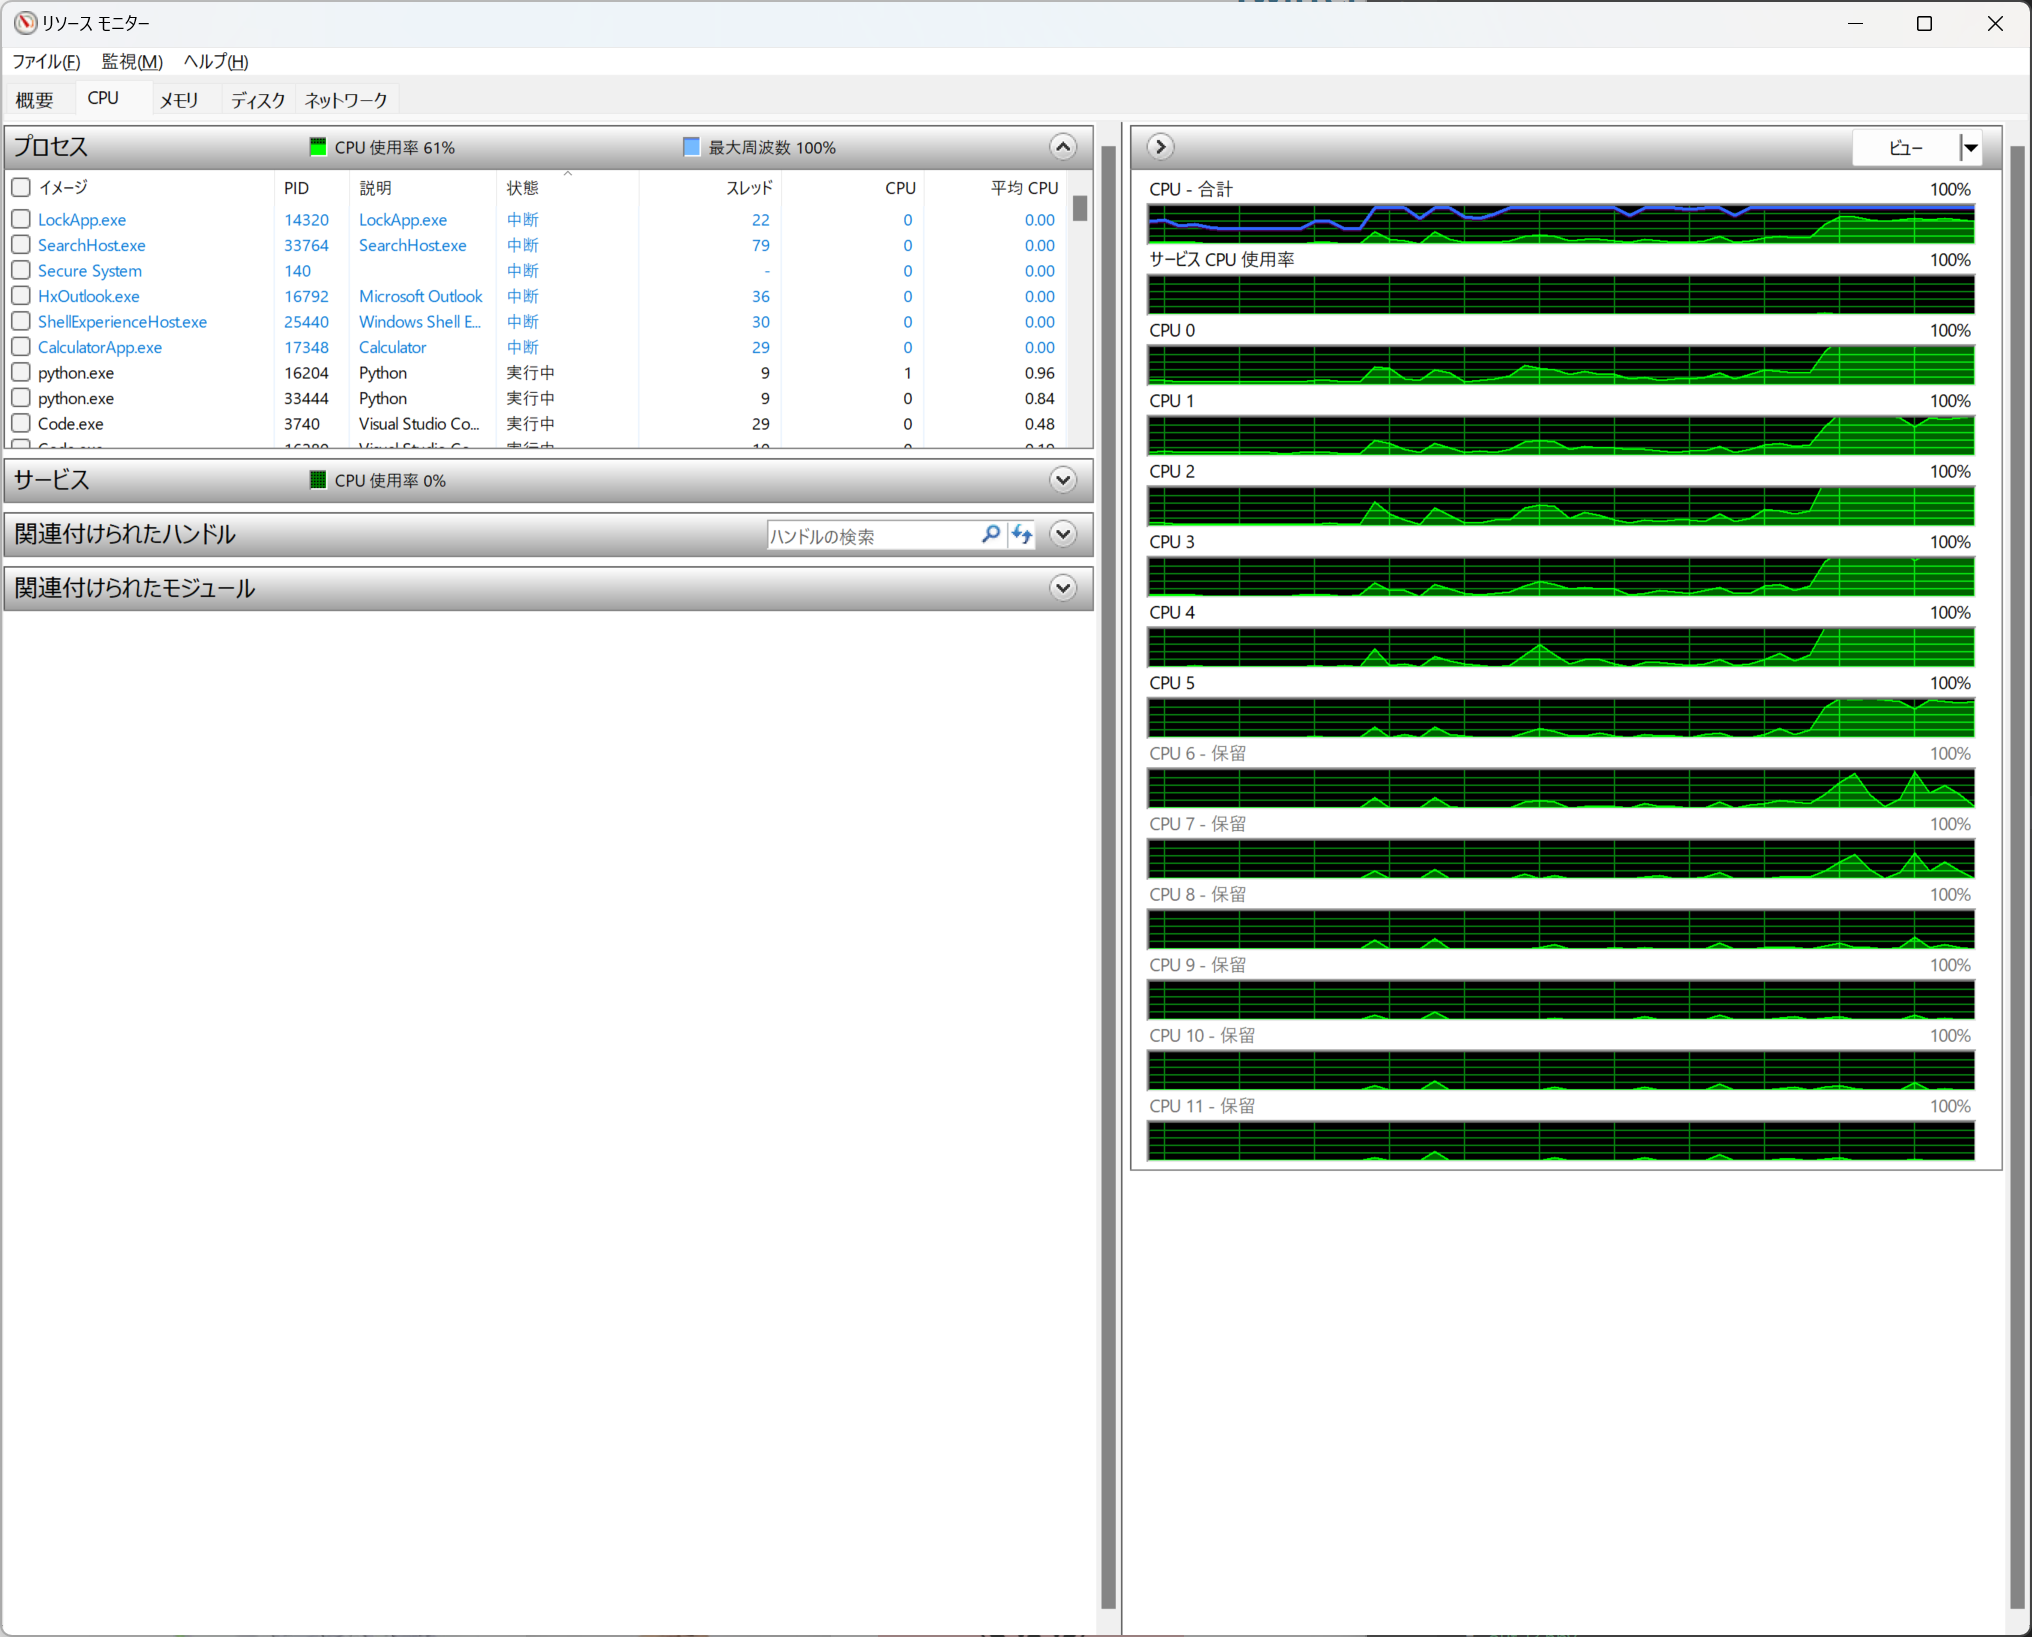
- CPU_COUNT = 4
TIMES = 100
N = 120
7.656297922134399
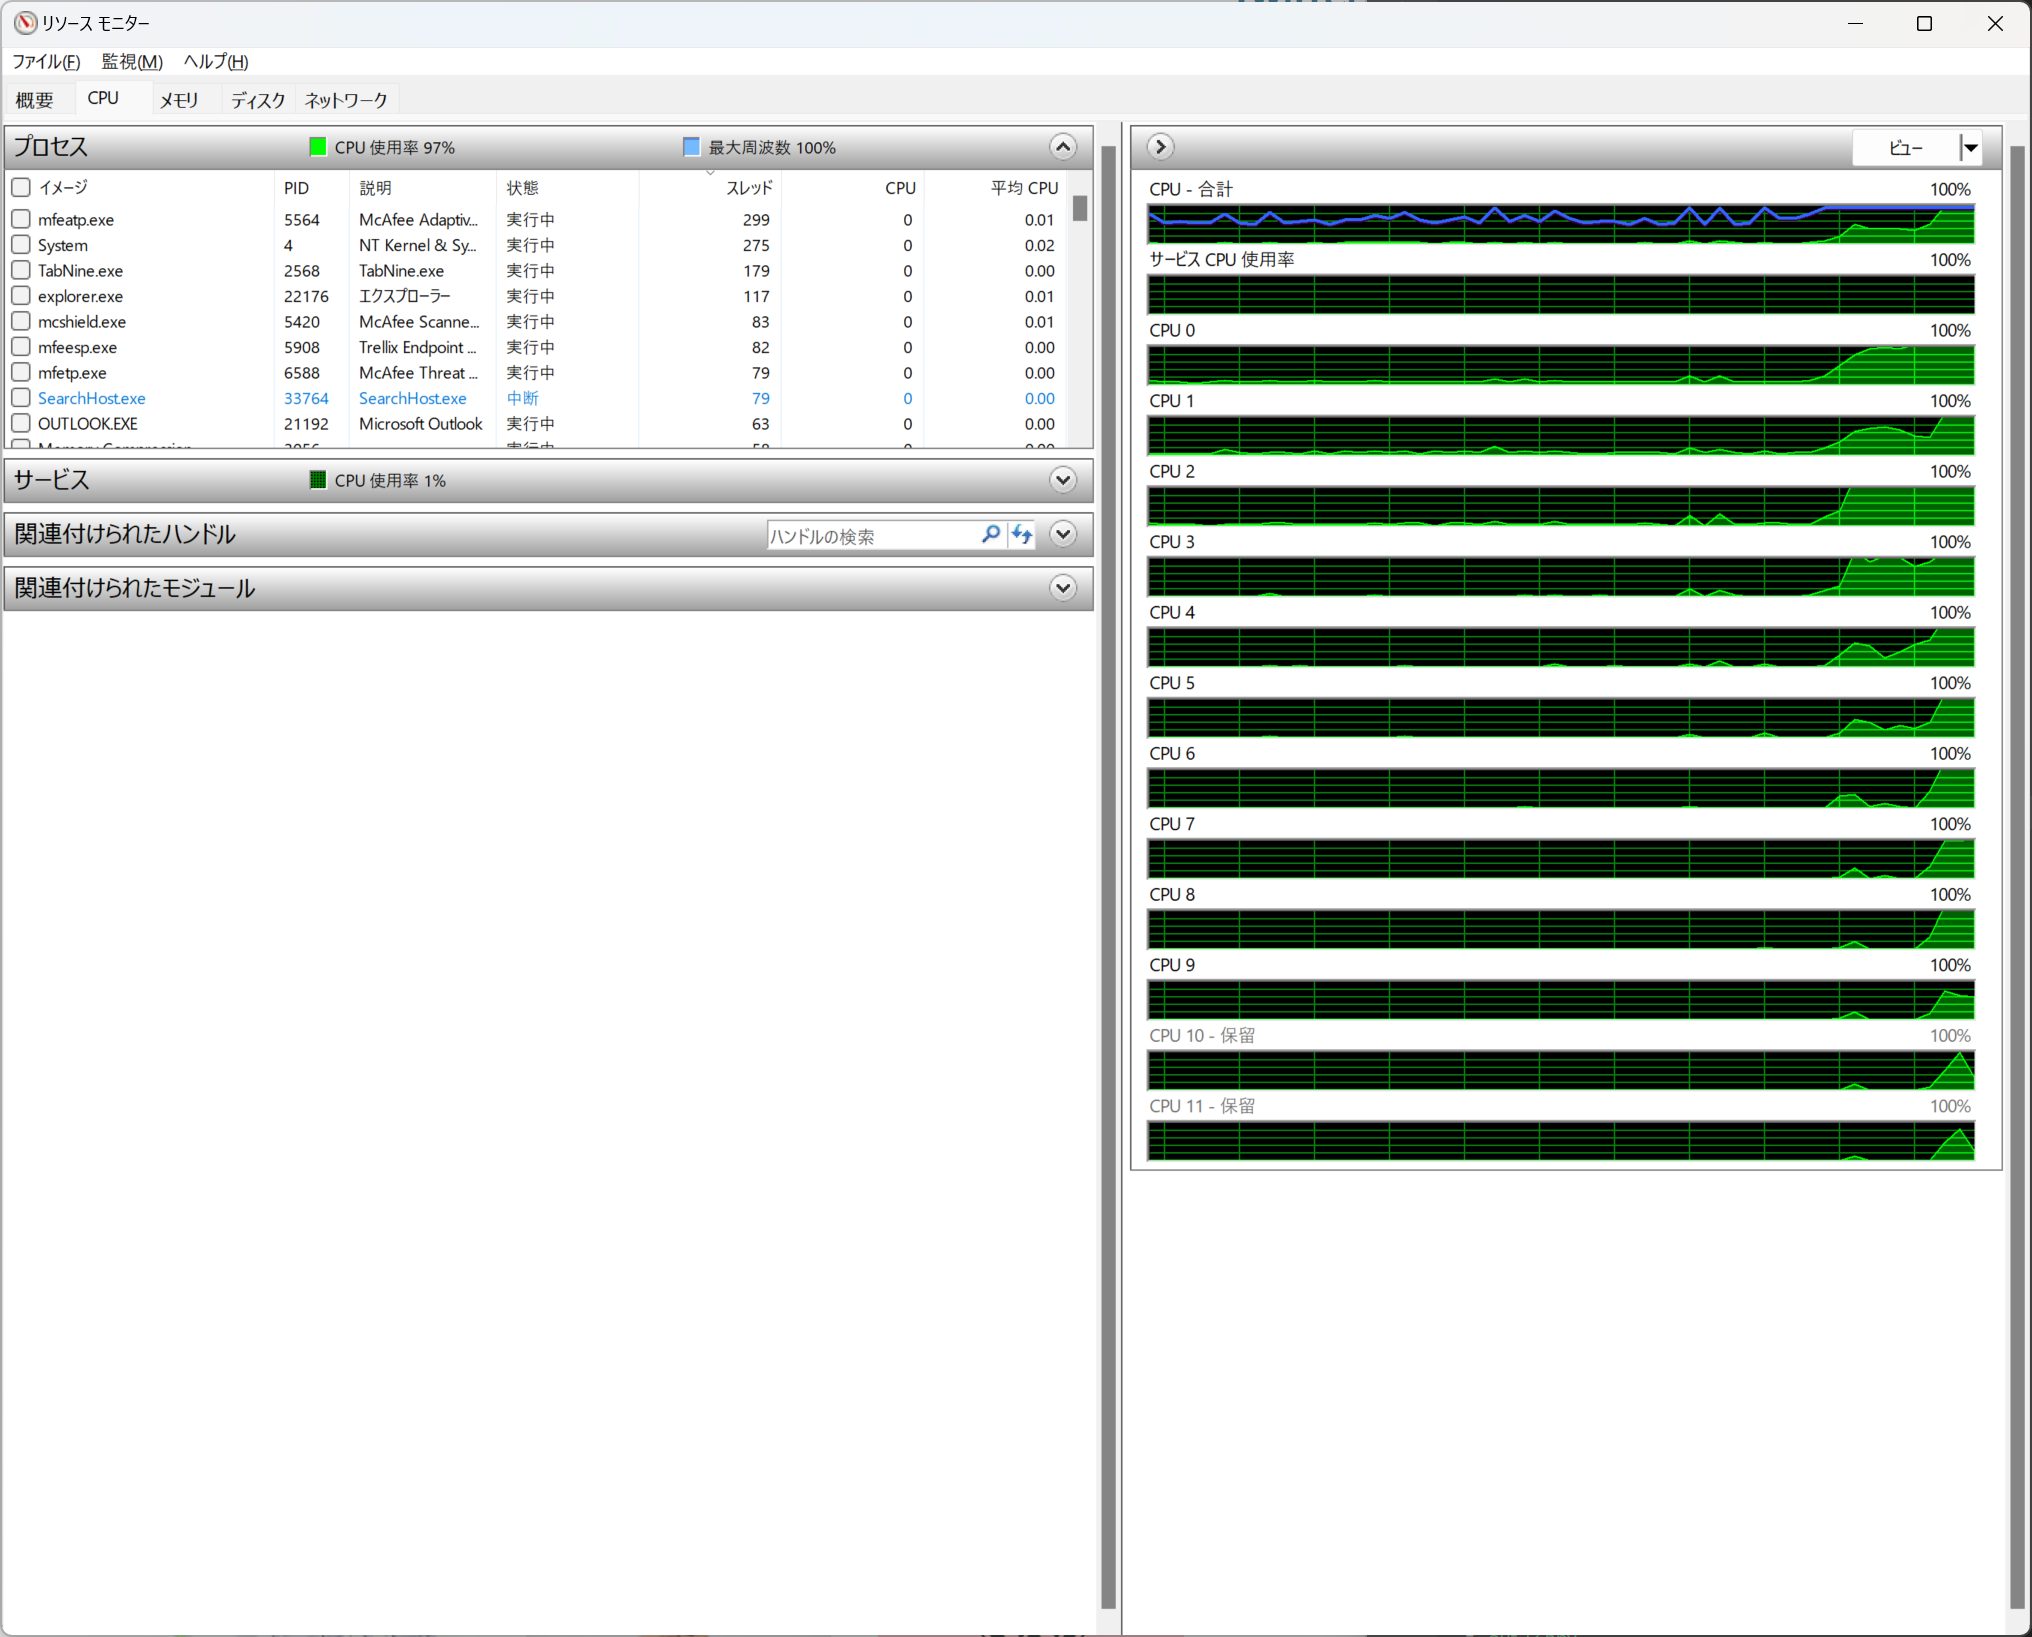
- CPU_COUNT = 6
TIMES = 100
N = 120
6.329265356063843
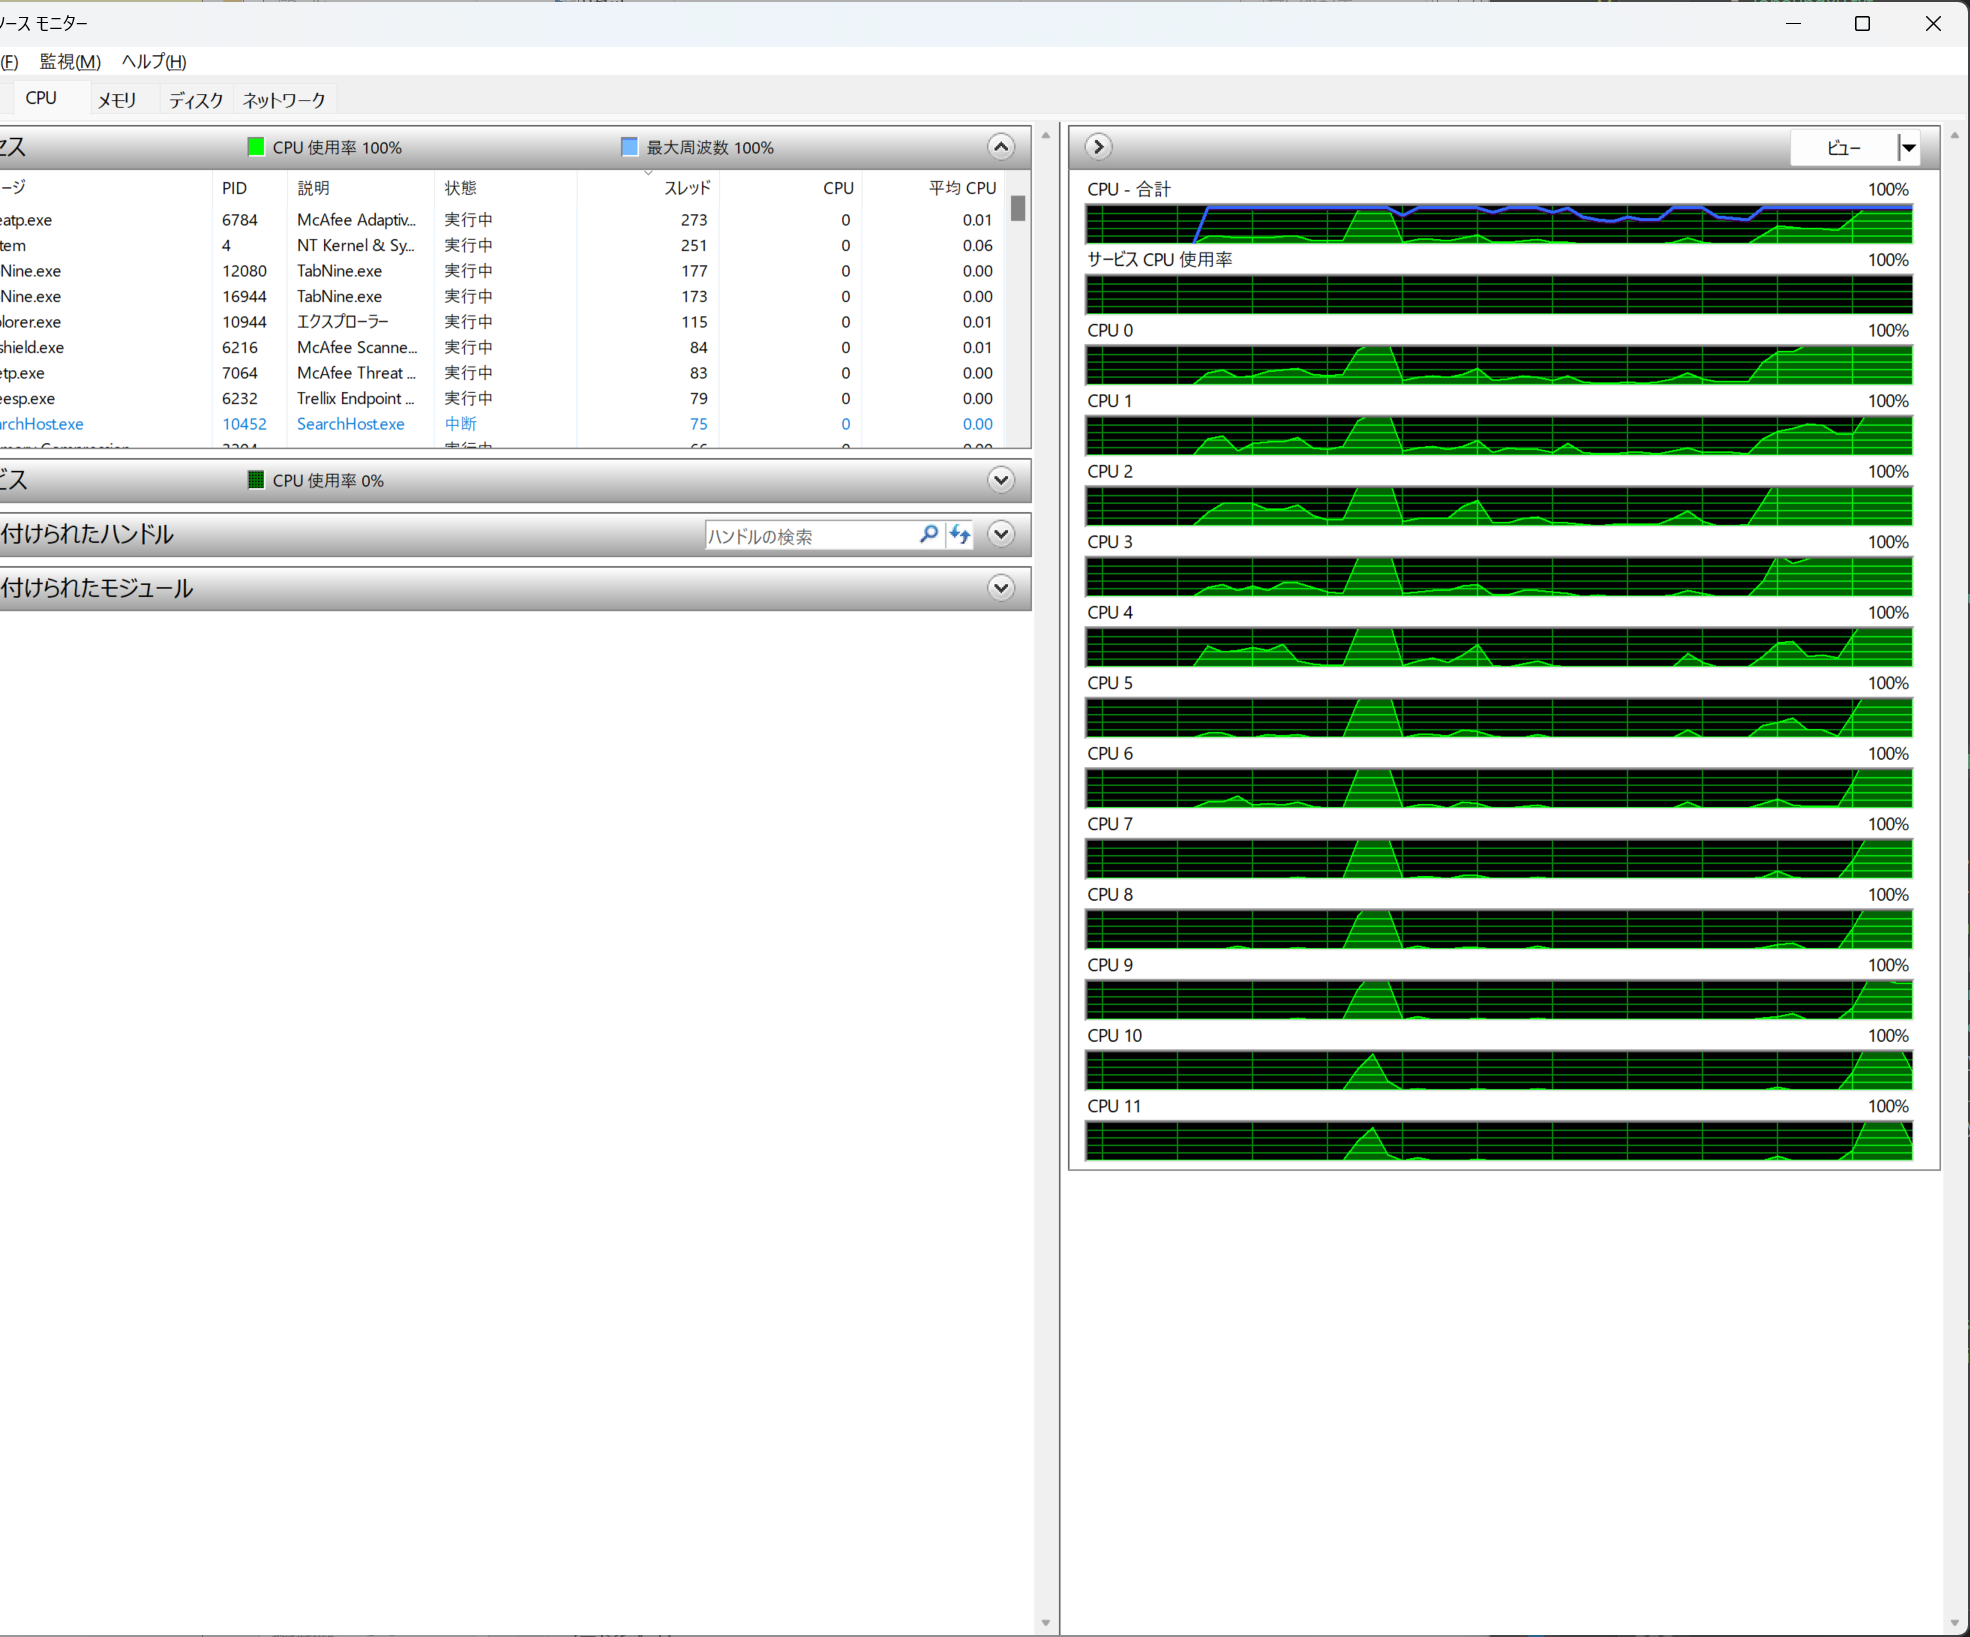
- CPU_COUNT = 8
TIMES = 100
N = 120
3.8012824058532715
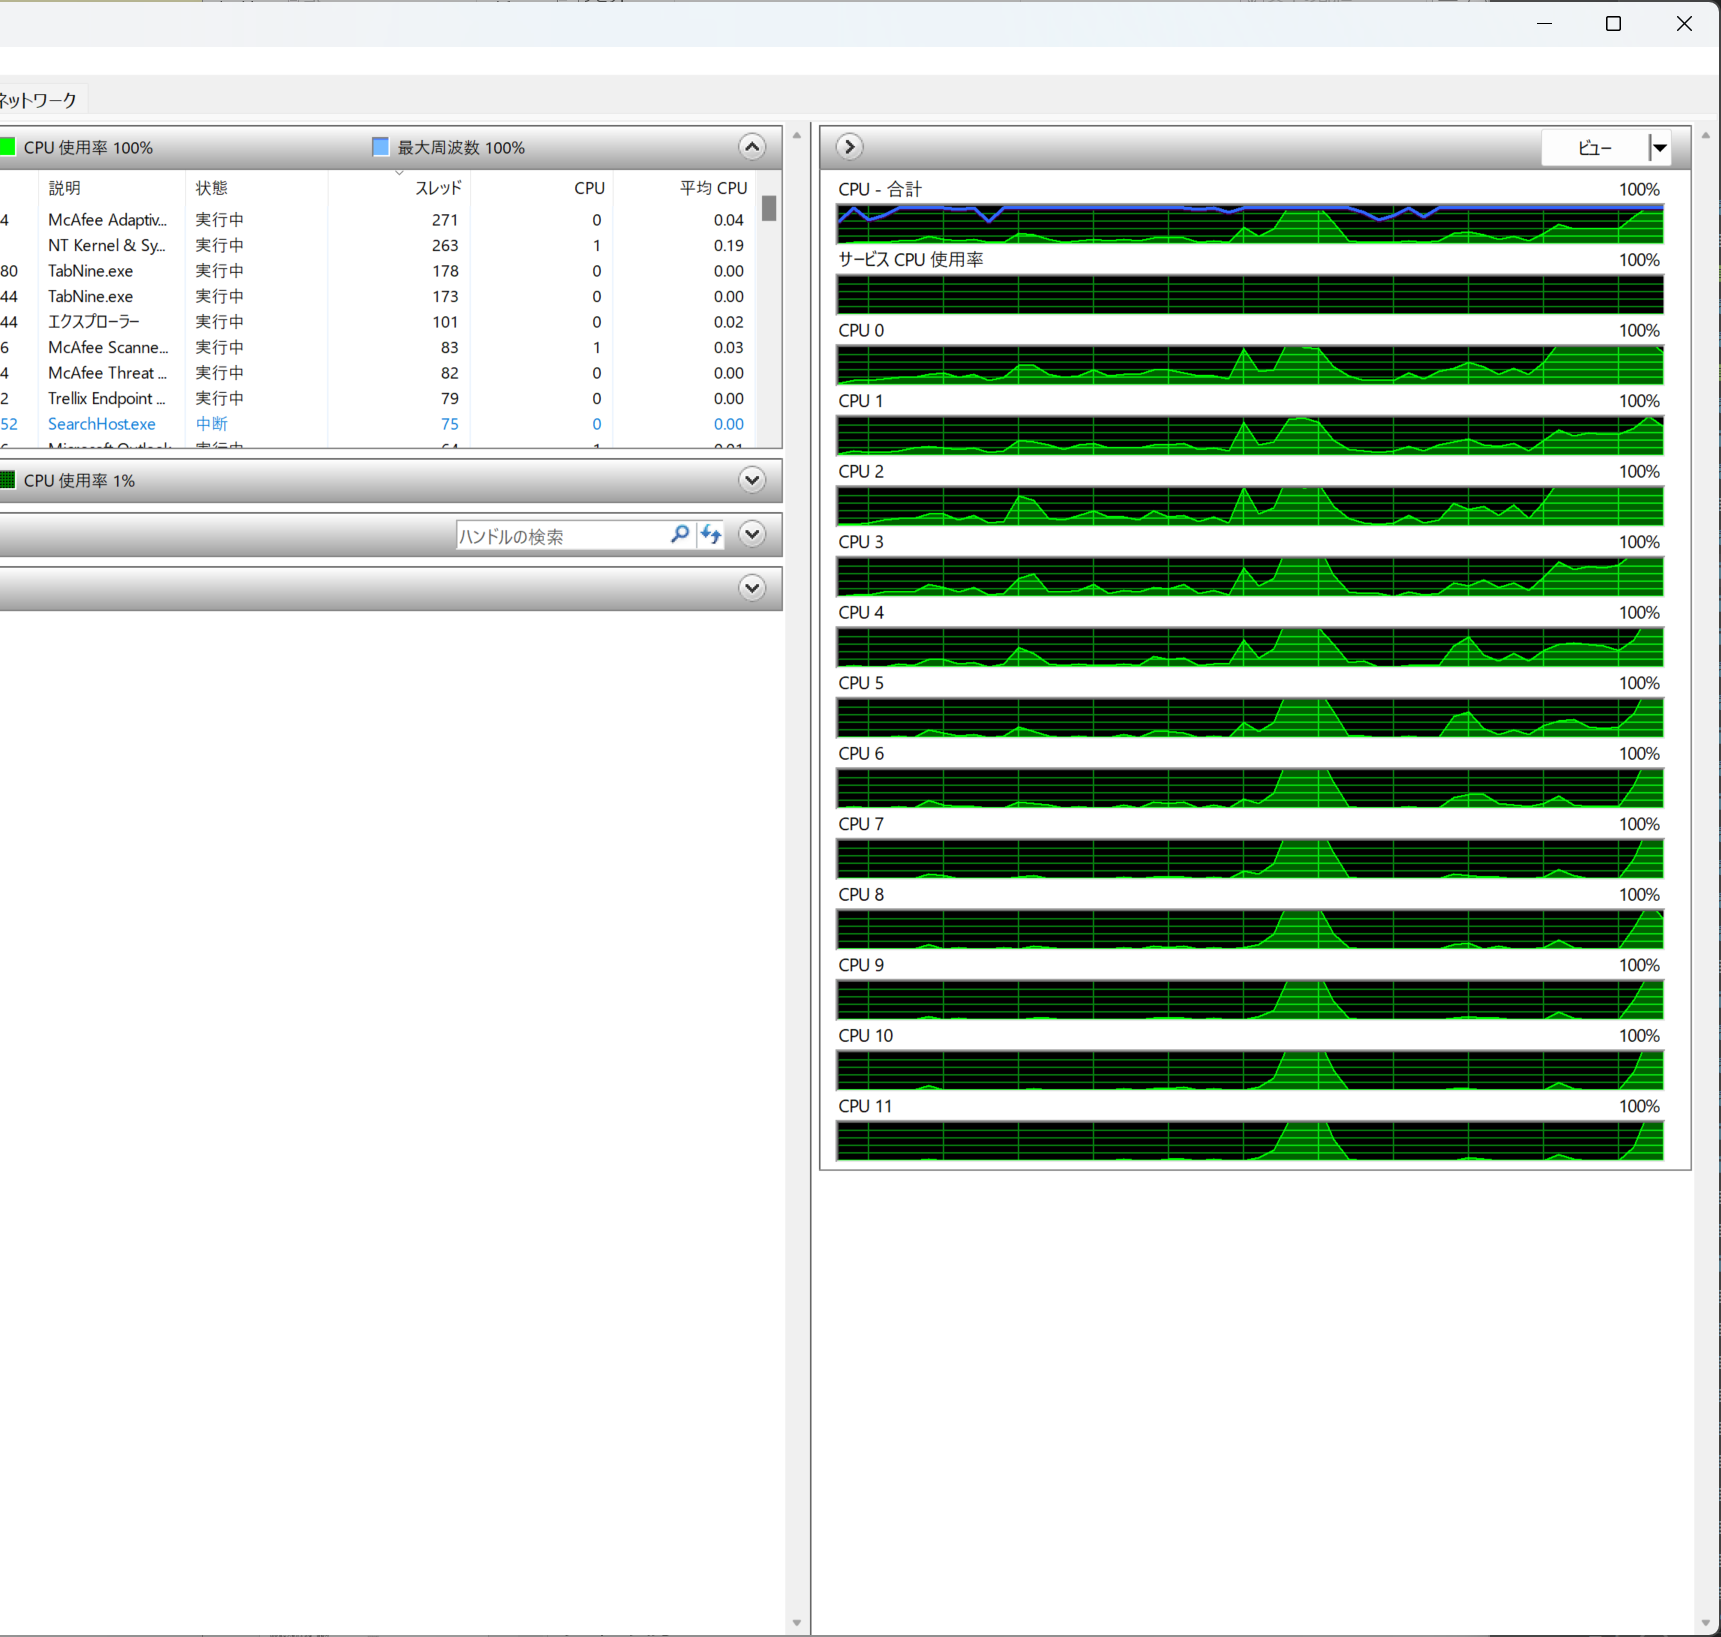
- CPU_COUNT = 10
TIMES = 100
N = 120
4.840173959732056
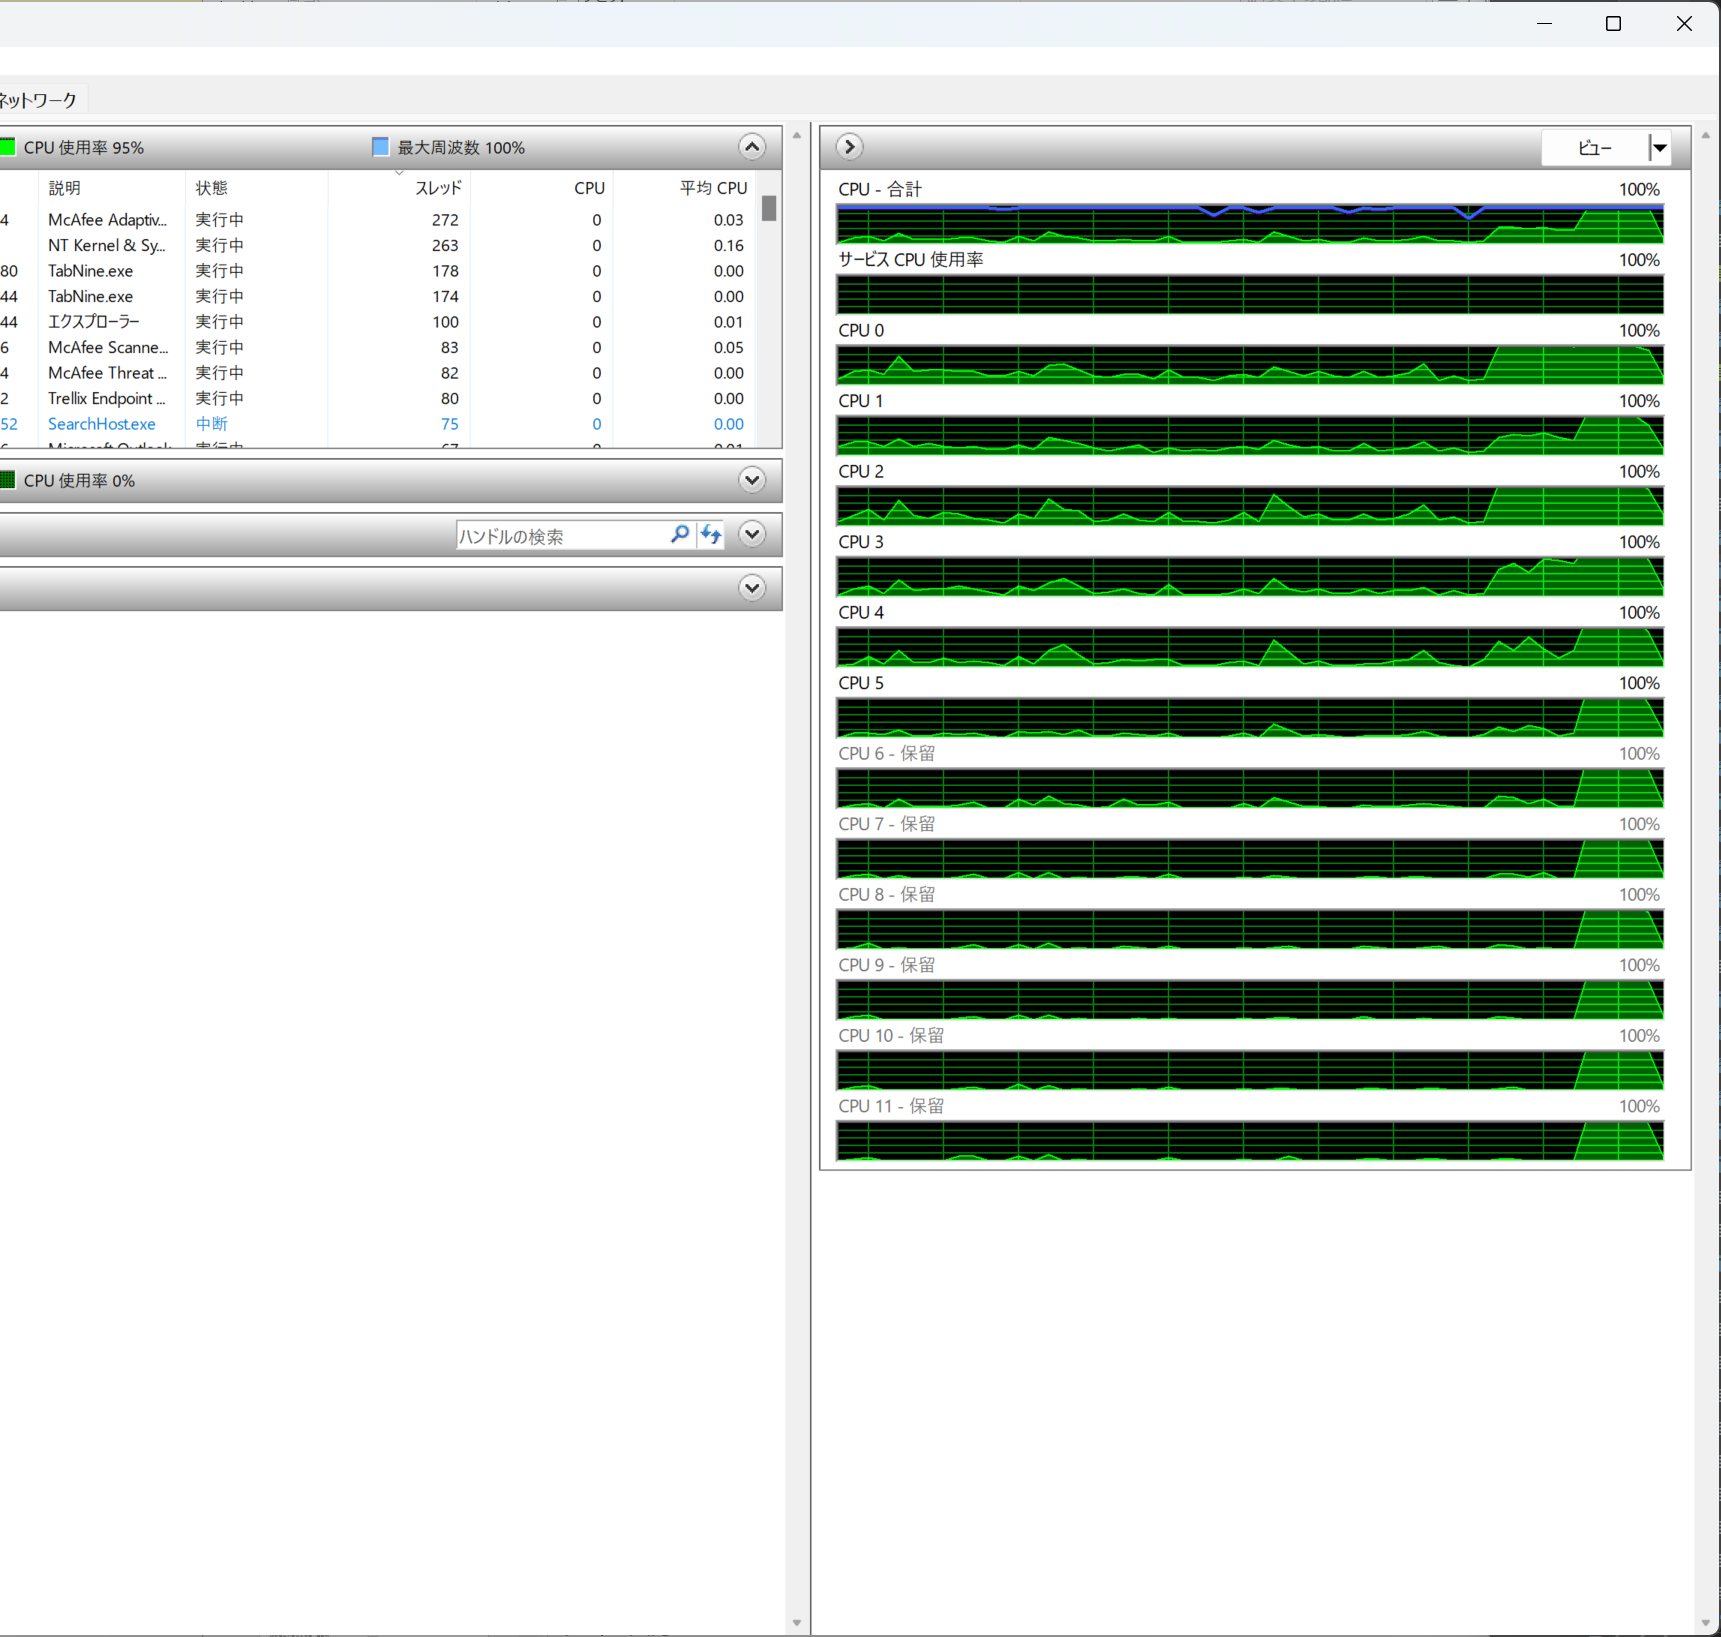
- CPU_COUNT = 12
TIMES = 100
N = 120
6.194876194000244
- CPU_COUNT = 2
TIMES = 100
N = 150
43.37623691558838
- PU_COUNT = 4
TIMES = 100
N = 150
13.879023551940918
- CPU_COUNT = 6
TIMES = 100
N = 150
9.918938636779785
- CPU_COUNT = 8
TIMES = 100
N = 150
4.648187637329102
- CPU_COUNT = 10
TIMES = 100
N = 150
5.768030405044556
- CPU_COUNT = 12
TIMES = 100
N = 150
6.6136510372161865
- CPU_COUNT = 1
TIMES = 24
N = 200
62.36888289451599
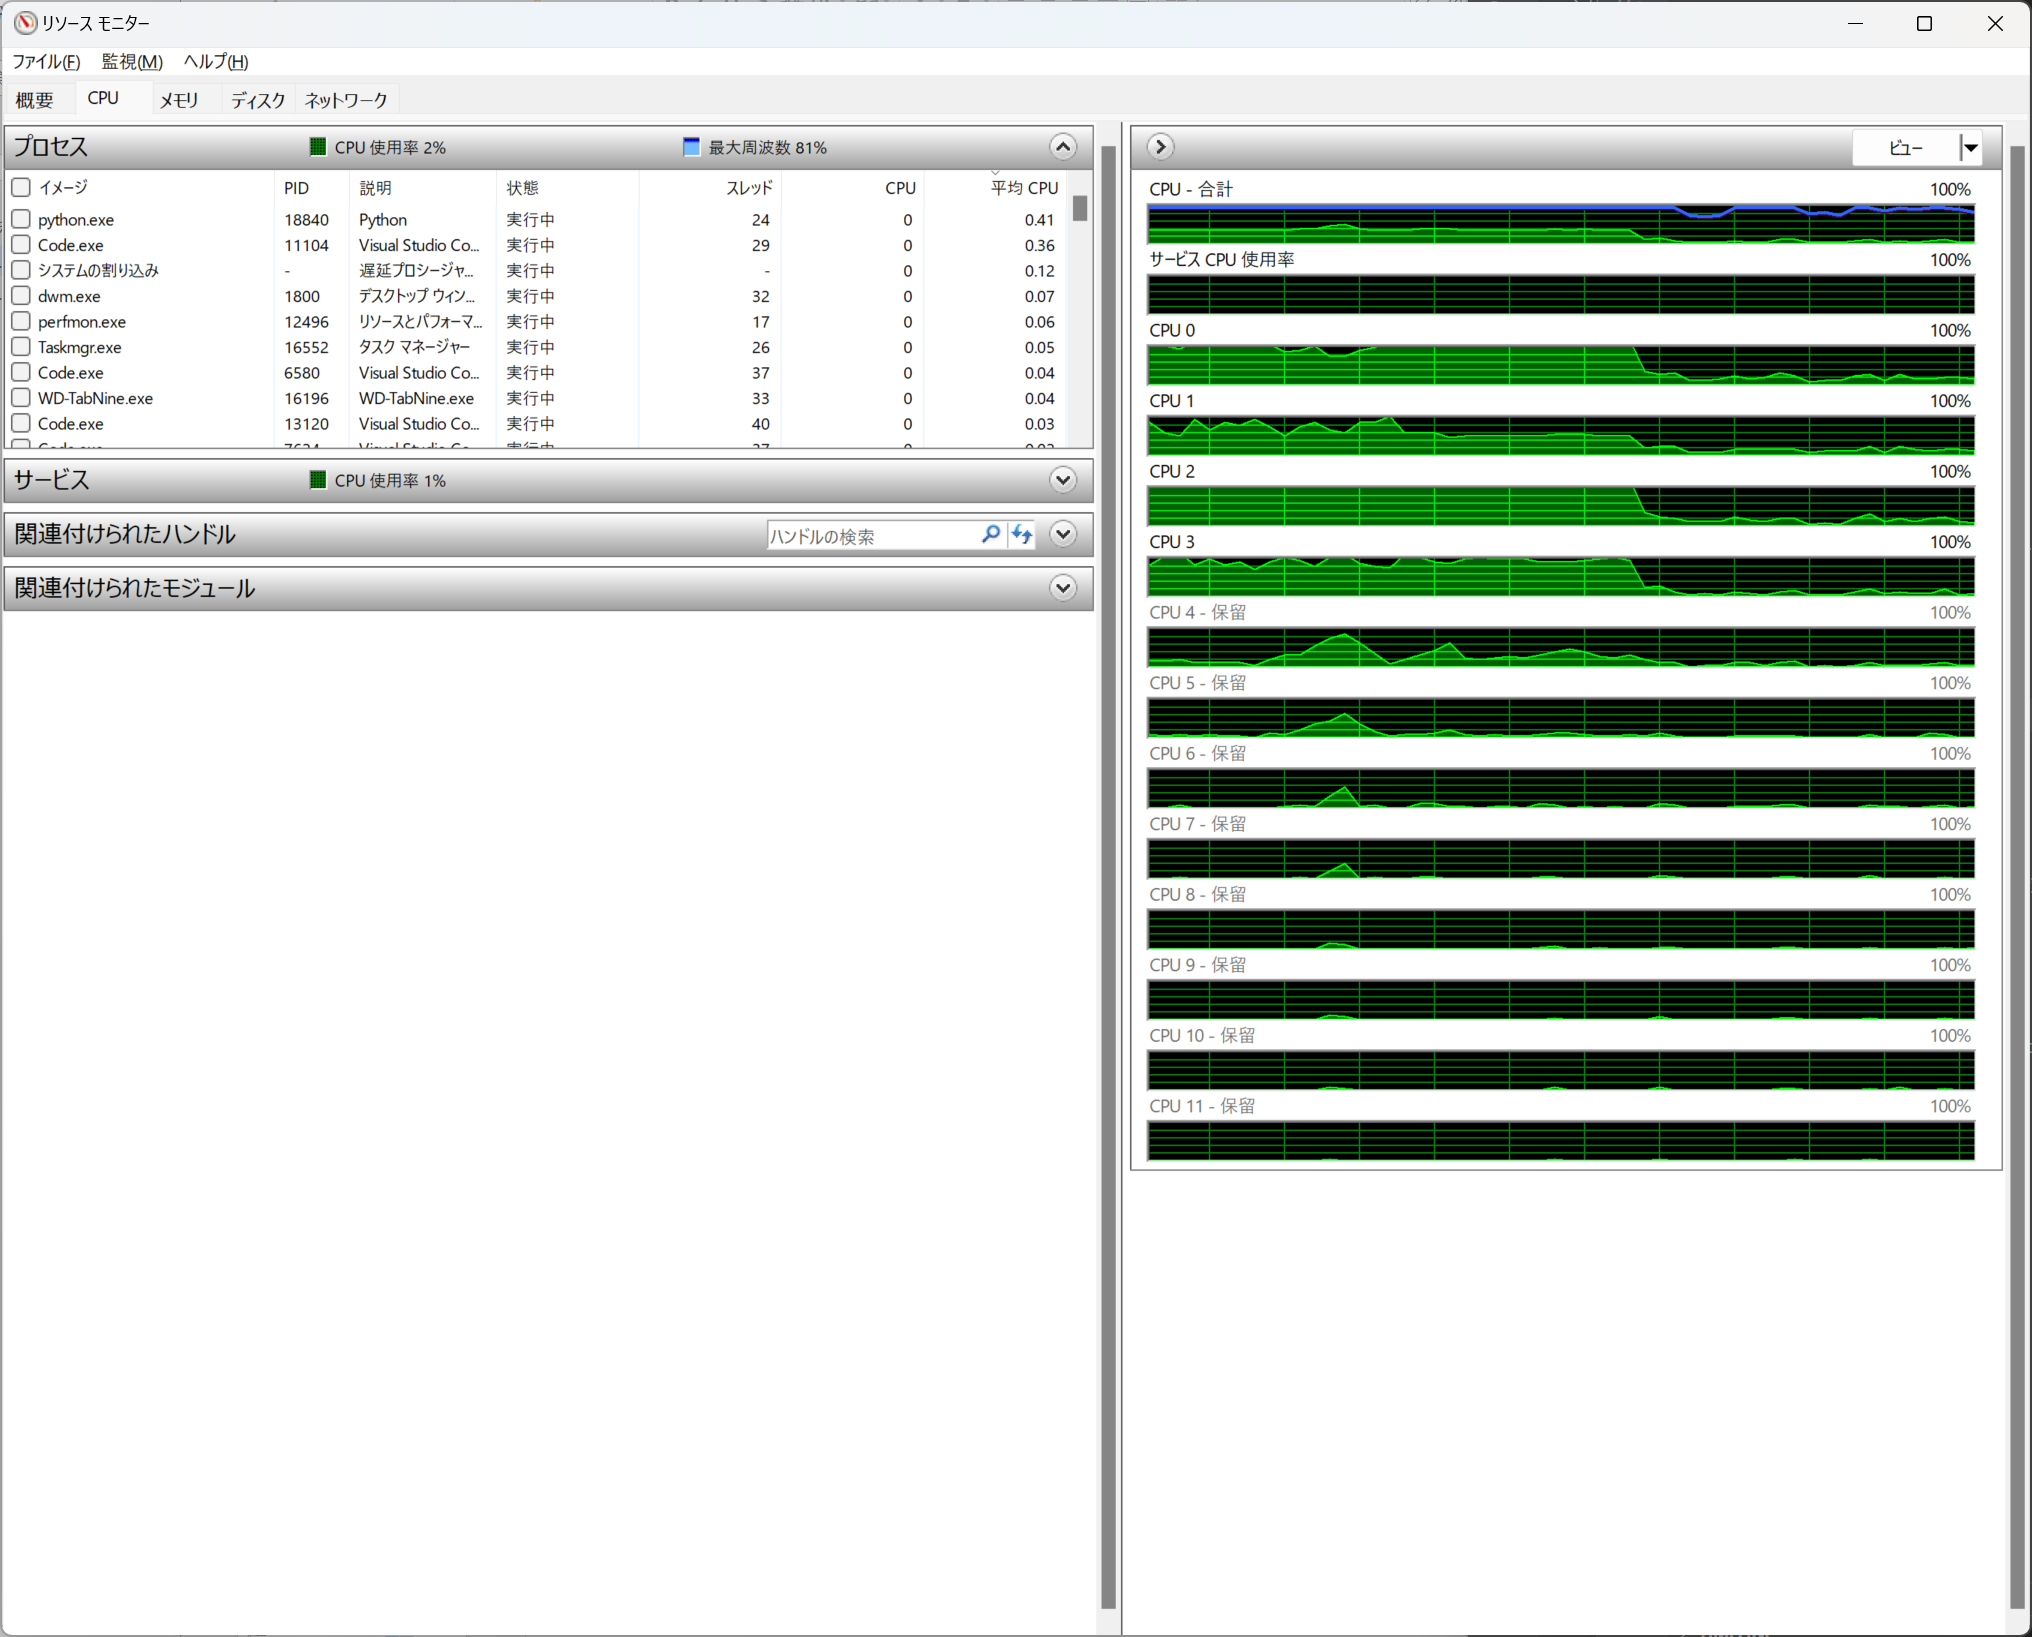
- CPU_COUNT = 2
TIMES = 24
N = 200
20.224487781524658
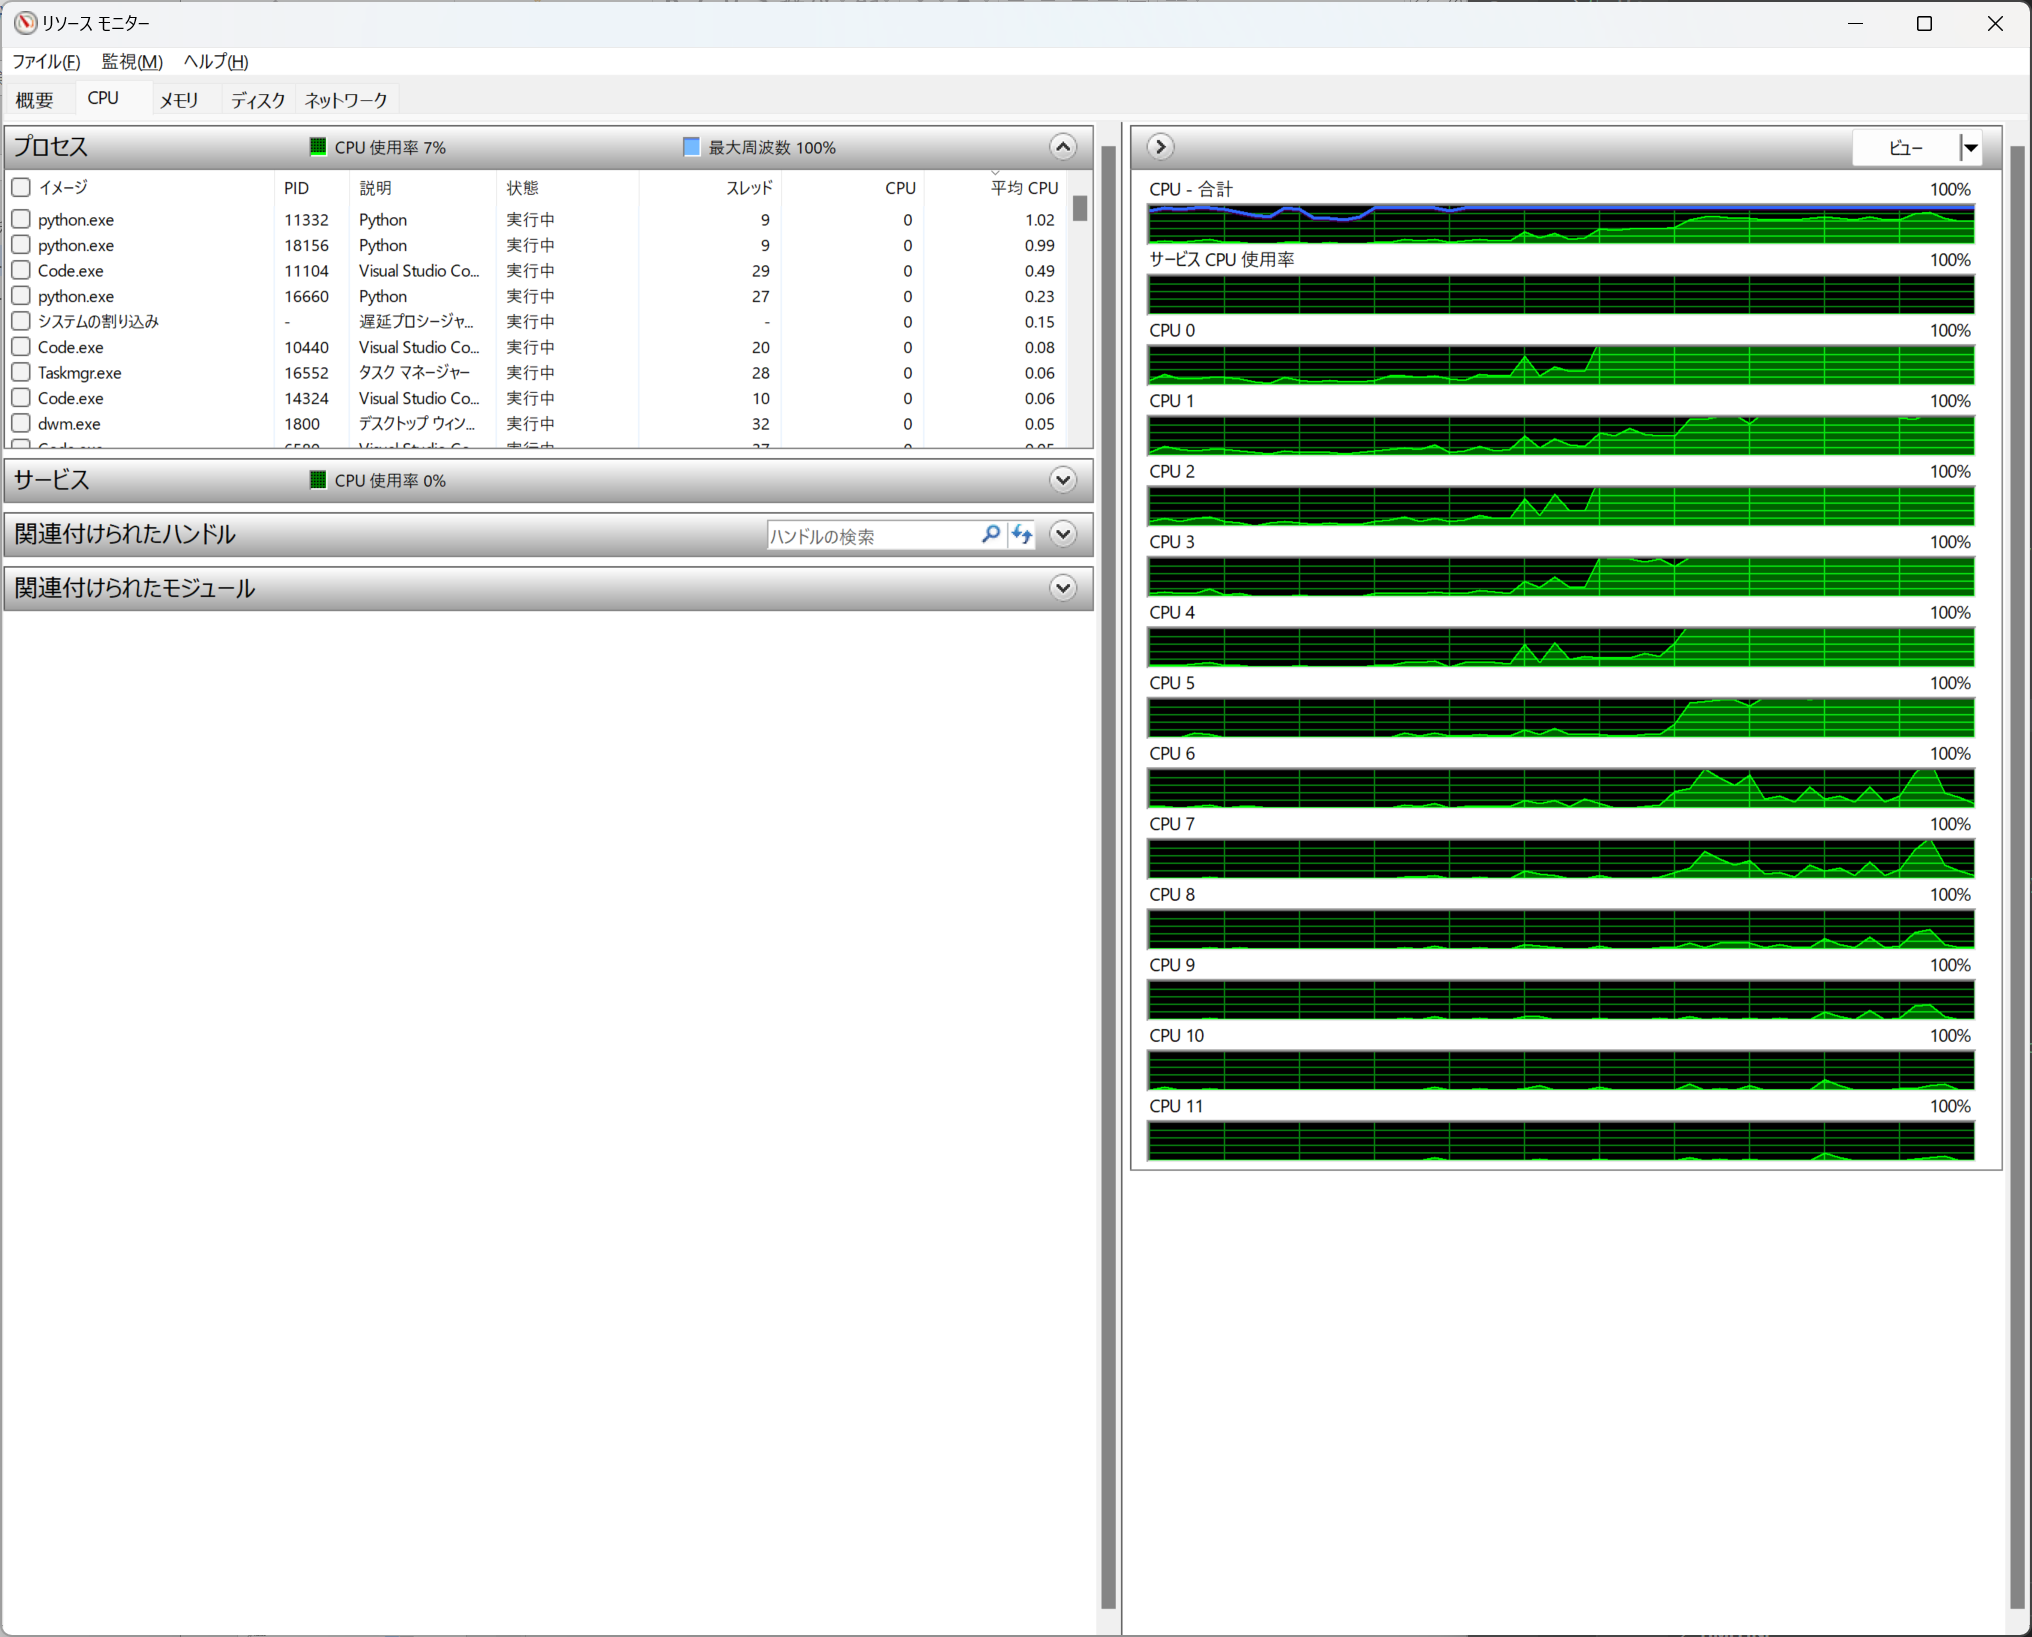
- CPU_COUNT = 4
TIMES = 24
N = 200
8.218902349472046
- CPU_COUNT = 6
TIMES = 24
N = 200
6.6538920402526855
- CPU_COUNT = 8
TIMES = 24
N = 200
4.175506830215454
- CPU_COUNT = 10
TIMES = 24
N = 200
4.933730125427246
- CPU_COUNT = 12
TIMES = 24
N = 200
6.159997940063477


### ソースコードベタ打ちの効果を確かめる

In [2]:
from joblib import Parallel, delayed
import time
import numpy as np

def wrap_calc(args):
    # print(args)
    return calc(*args)

def calc(A, n):

    a = np.random.random((n, n))

    b = np.random.random((n, n))
    c = np.dot(a, b).reshape([n*n])

    g = [gauss(i, a=A, mu=n*n/2, sigma=n*n/8) for i in range(n*n)]

    # ガウシアンとのコンボリューション
    conv =  np.convolve(c, g, mode='same')
    
    # x軸の定義
    x =  np.array([i for i in range(n*n)])

    #4次関数でのフィッティング
    f1, f2, f3, f4, f5 = np.polyfit(x, conv, 4)
    return f1, f2, f3, f4, f5
    # fit = [func(i, f1, f2, f3, f4, f5) for i in x]

def gauss(x, a=1, mu=0, sigma=1):
    return a * np.exp(-(x - mu)**2 / (2*sigma**2))

CPU_COUNT = 6
TIMES = 500
N = 150

job_args = [(i, N) for i in range(TIMES)]

start = time.time()

for result in Parallel(n_jobs=CPU_COUNT) ([delayed(wrap_calc) (args) for args in job_args]):
    pass
    # print(result)

print(time.time()-start)


30.970653772354126


- CPU_COUNT = 1
TIMES = 100
N = 120
56.57072305679321
- CPU_COUNT = 2
TIMES = 100
N = 120
16.48804497718811
- CPU_COUNT = 4
TIMES = 100
N = 120
5.196465015411377
- CPU_COUNT = 6
TIMES = 100
N = 120
3.4273998737335205
- CPU_COUNT = 8
TIMES = 100
N = 120
1.829620599746704
- CPU_COUNT = 10
TIMES = 100
N = 120
2.0630264282226562
- CPU_COUNT = 12
TIMES = 100
N = 120
2.358685255050659
- CPU_COUNT = 6
TIMES = 100
N = 150
7.114055156707764
- CPU_COUNT = 8
TIMES = 100
N = 150
2.6081085205078125
- CPU_COUNT = 2
TIMES = 24
N = 200
16.646991968154907
- CPU_COUNT = 4
TIMES = 24
N = 200
5.842790842056274
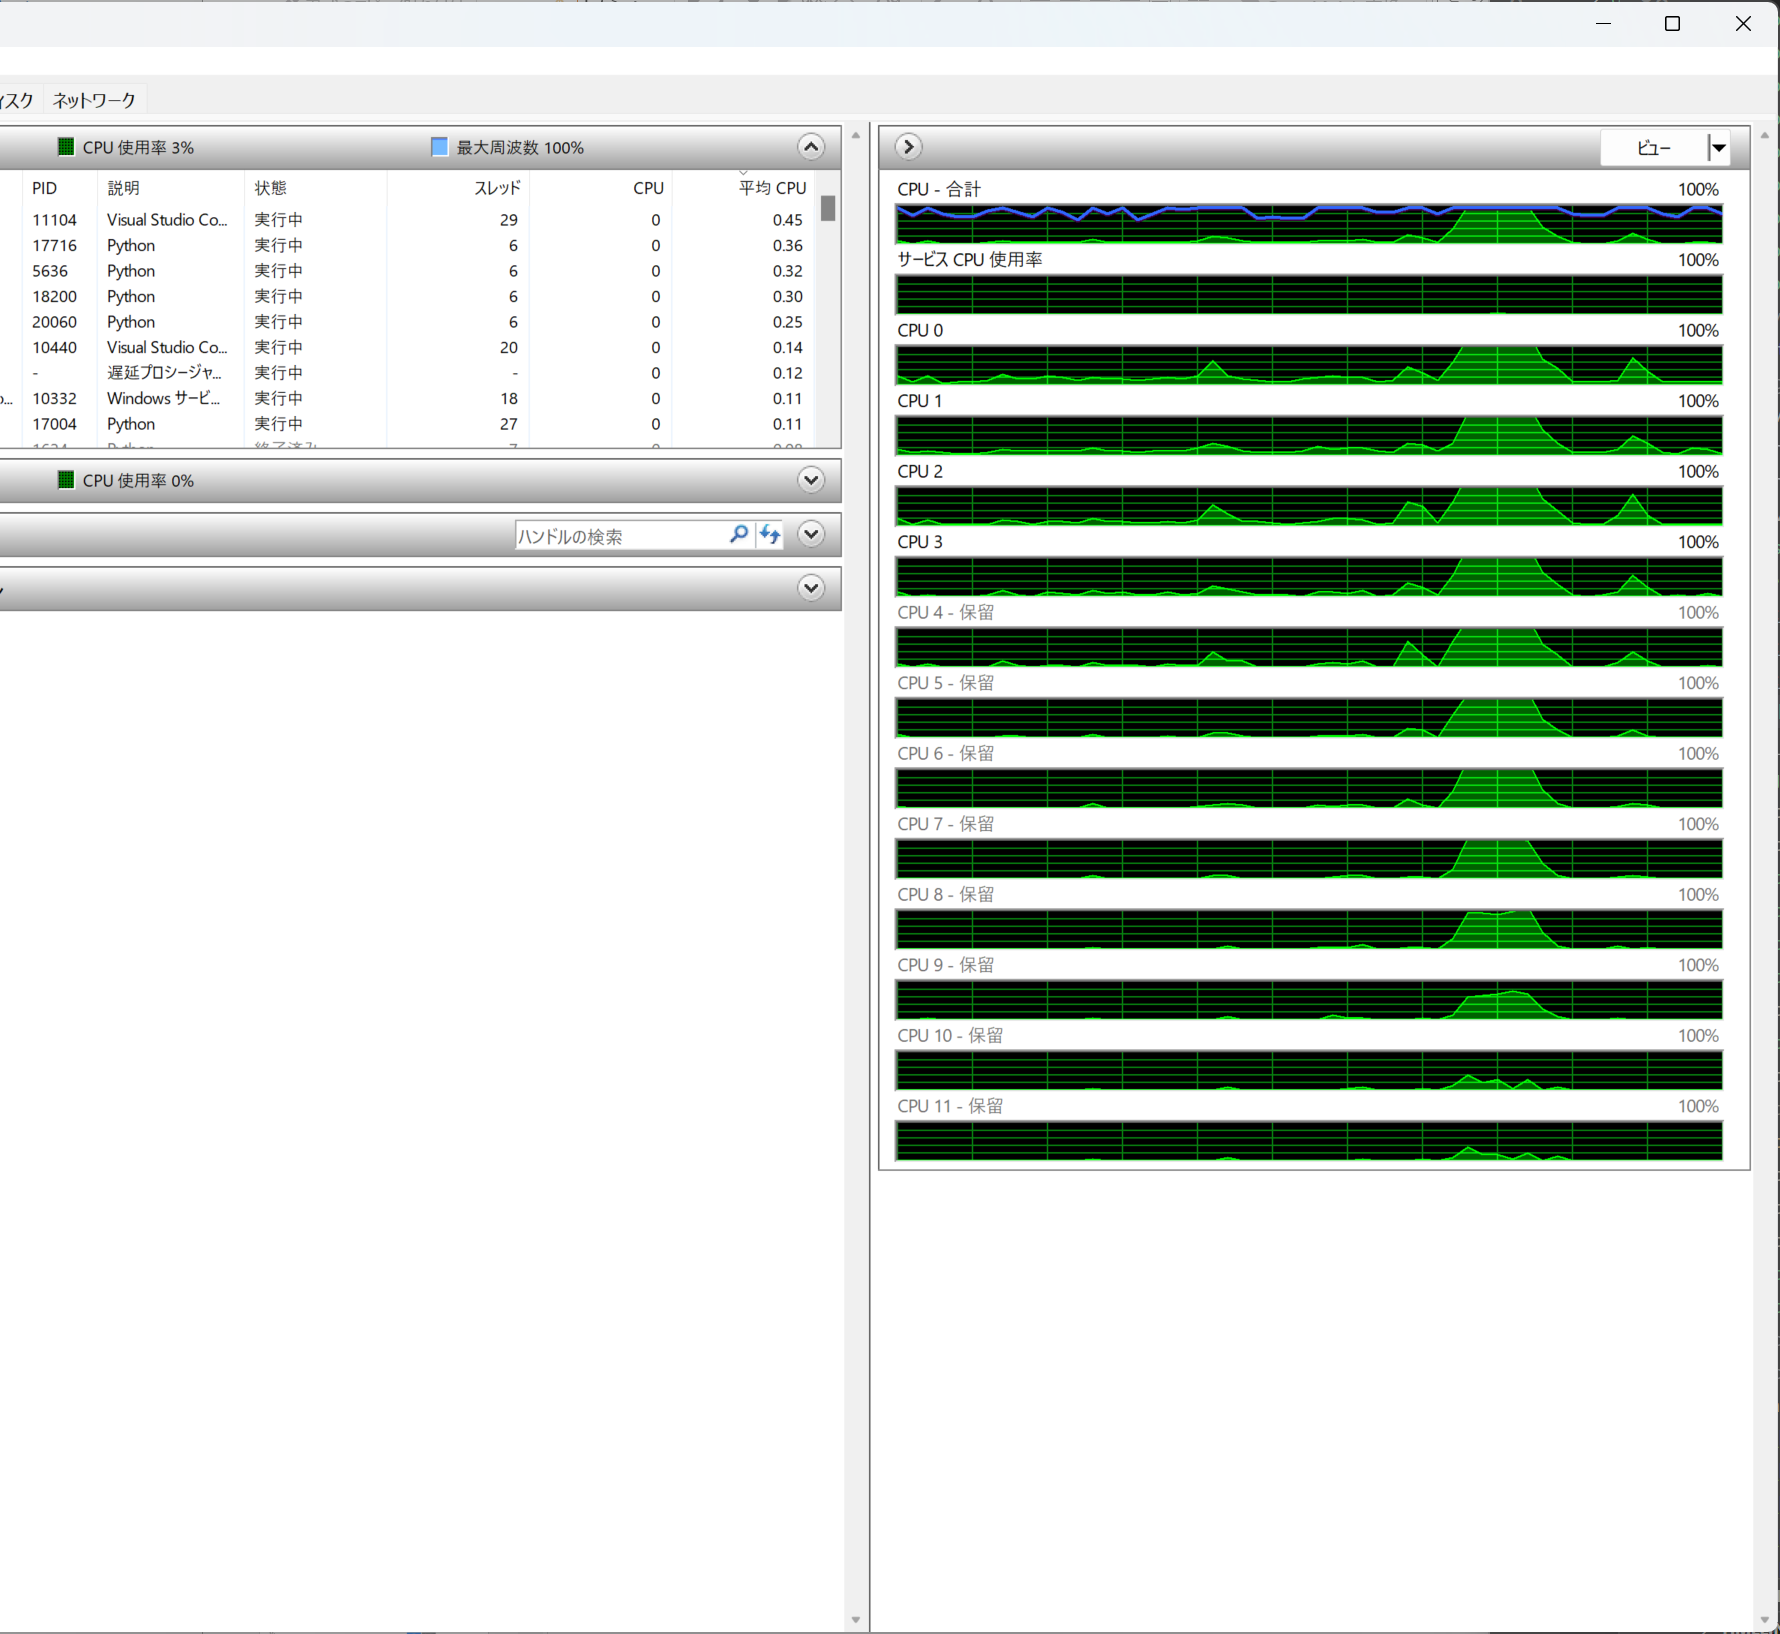
- CPU_COUNT = 4
TIMES = 25
N = 200
6.3791663646698
- CPU_COUNT = 5
TIMES = 24
N = 200
4.568622350692749
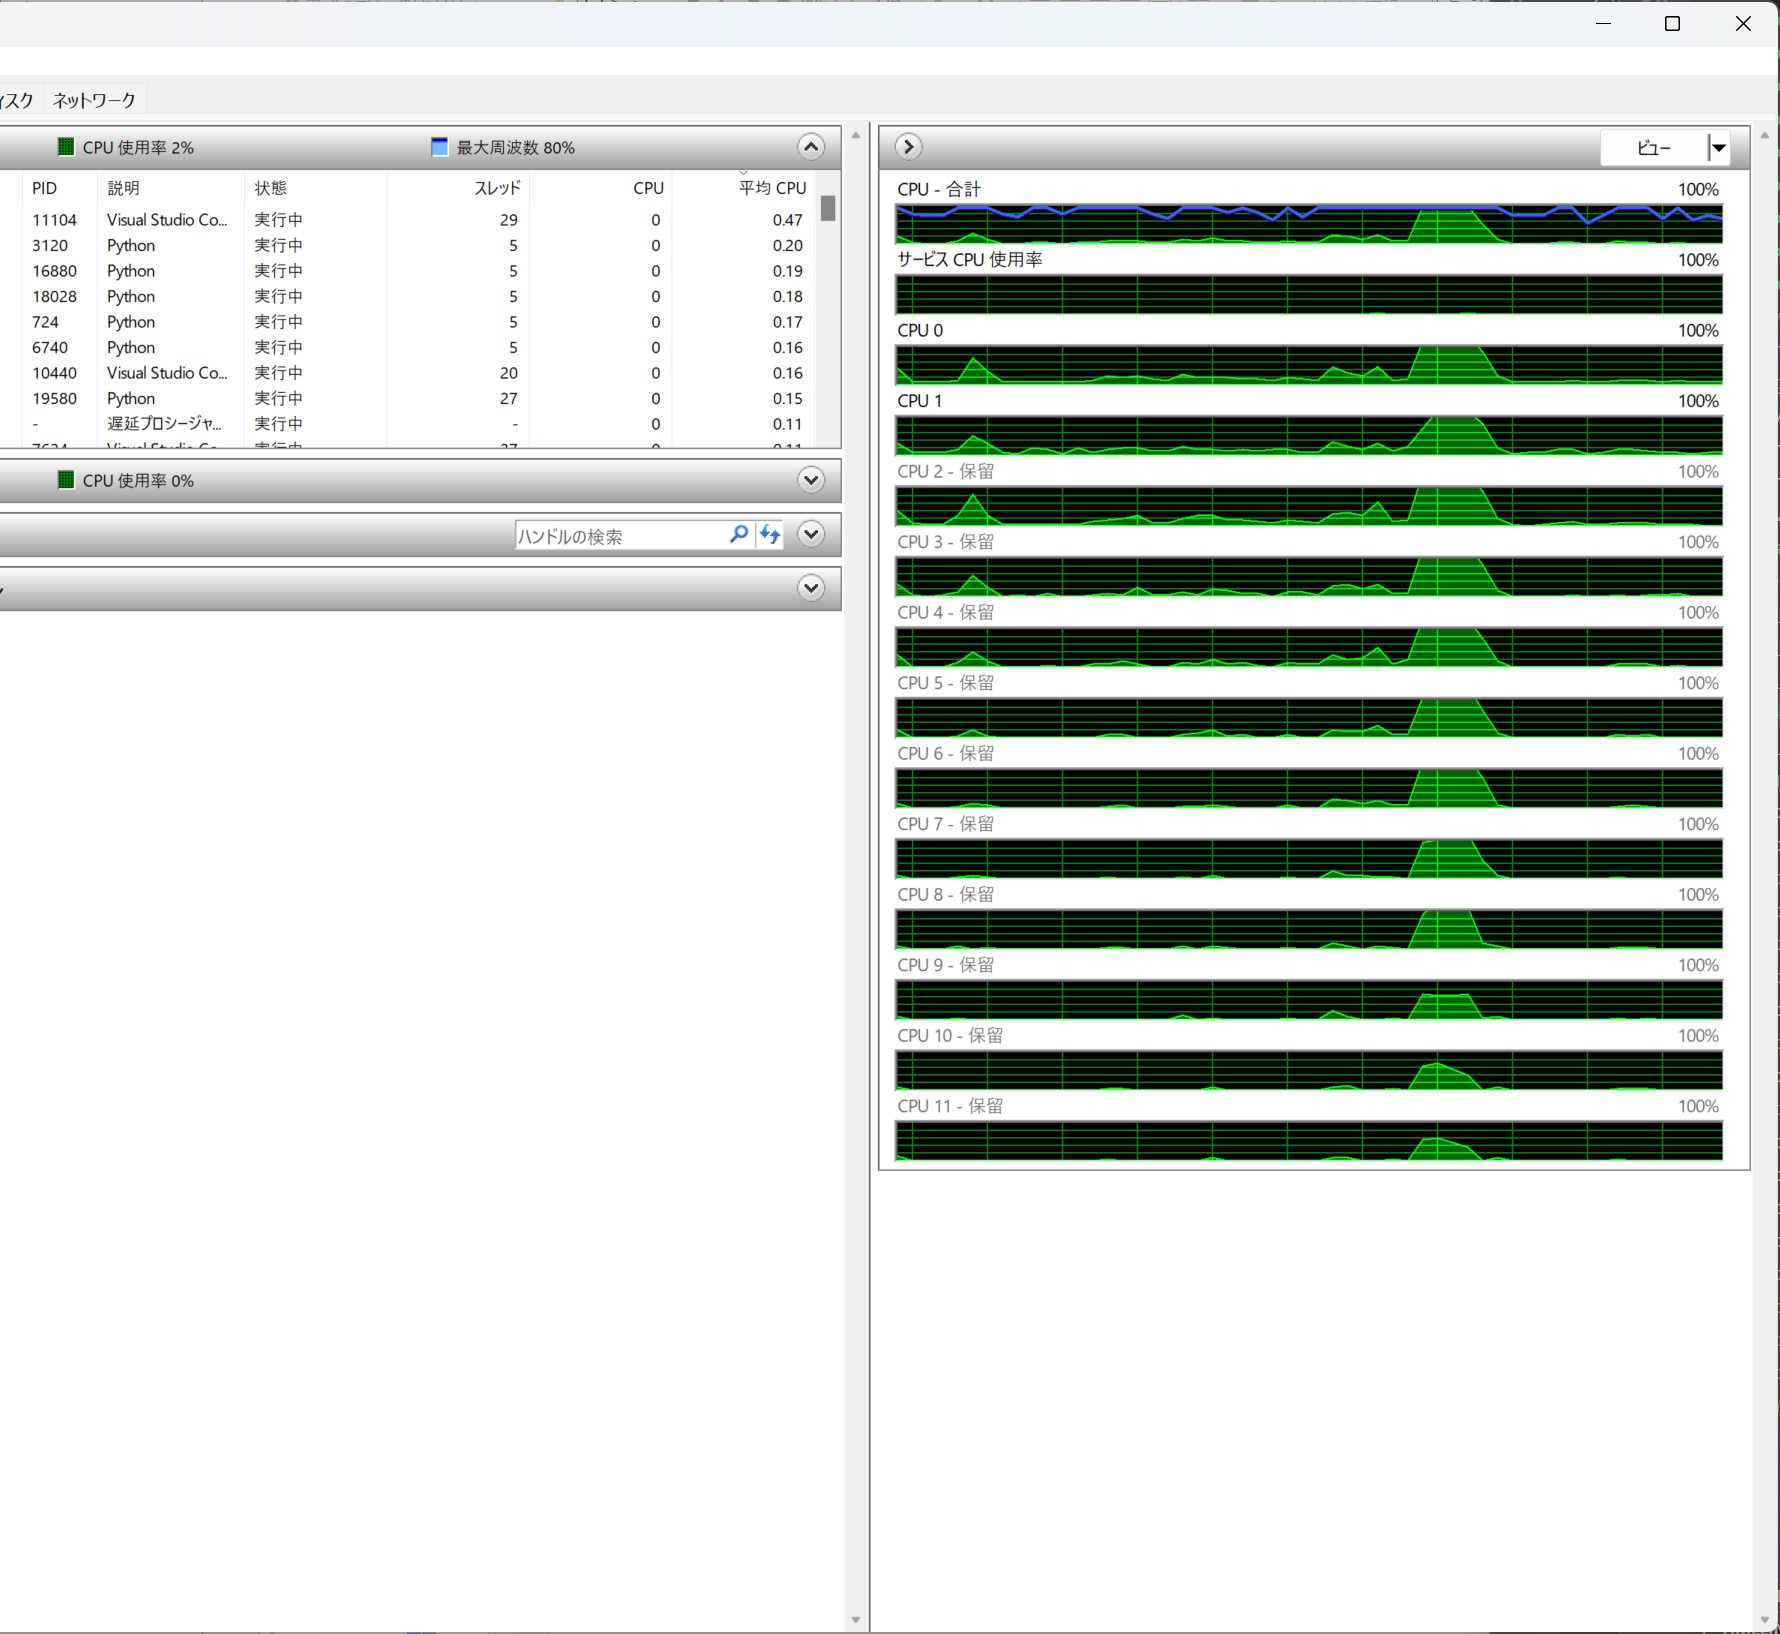
- CPU_COUNT = 6
TIMES = 24
N = 200
4.0602357387542725
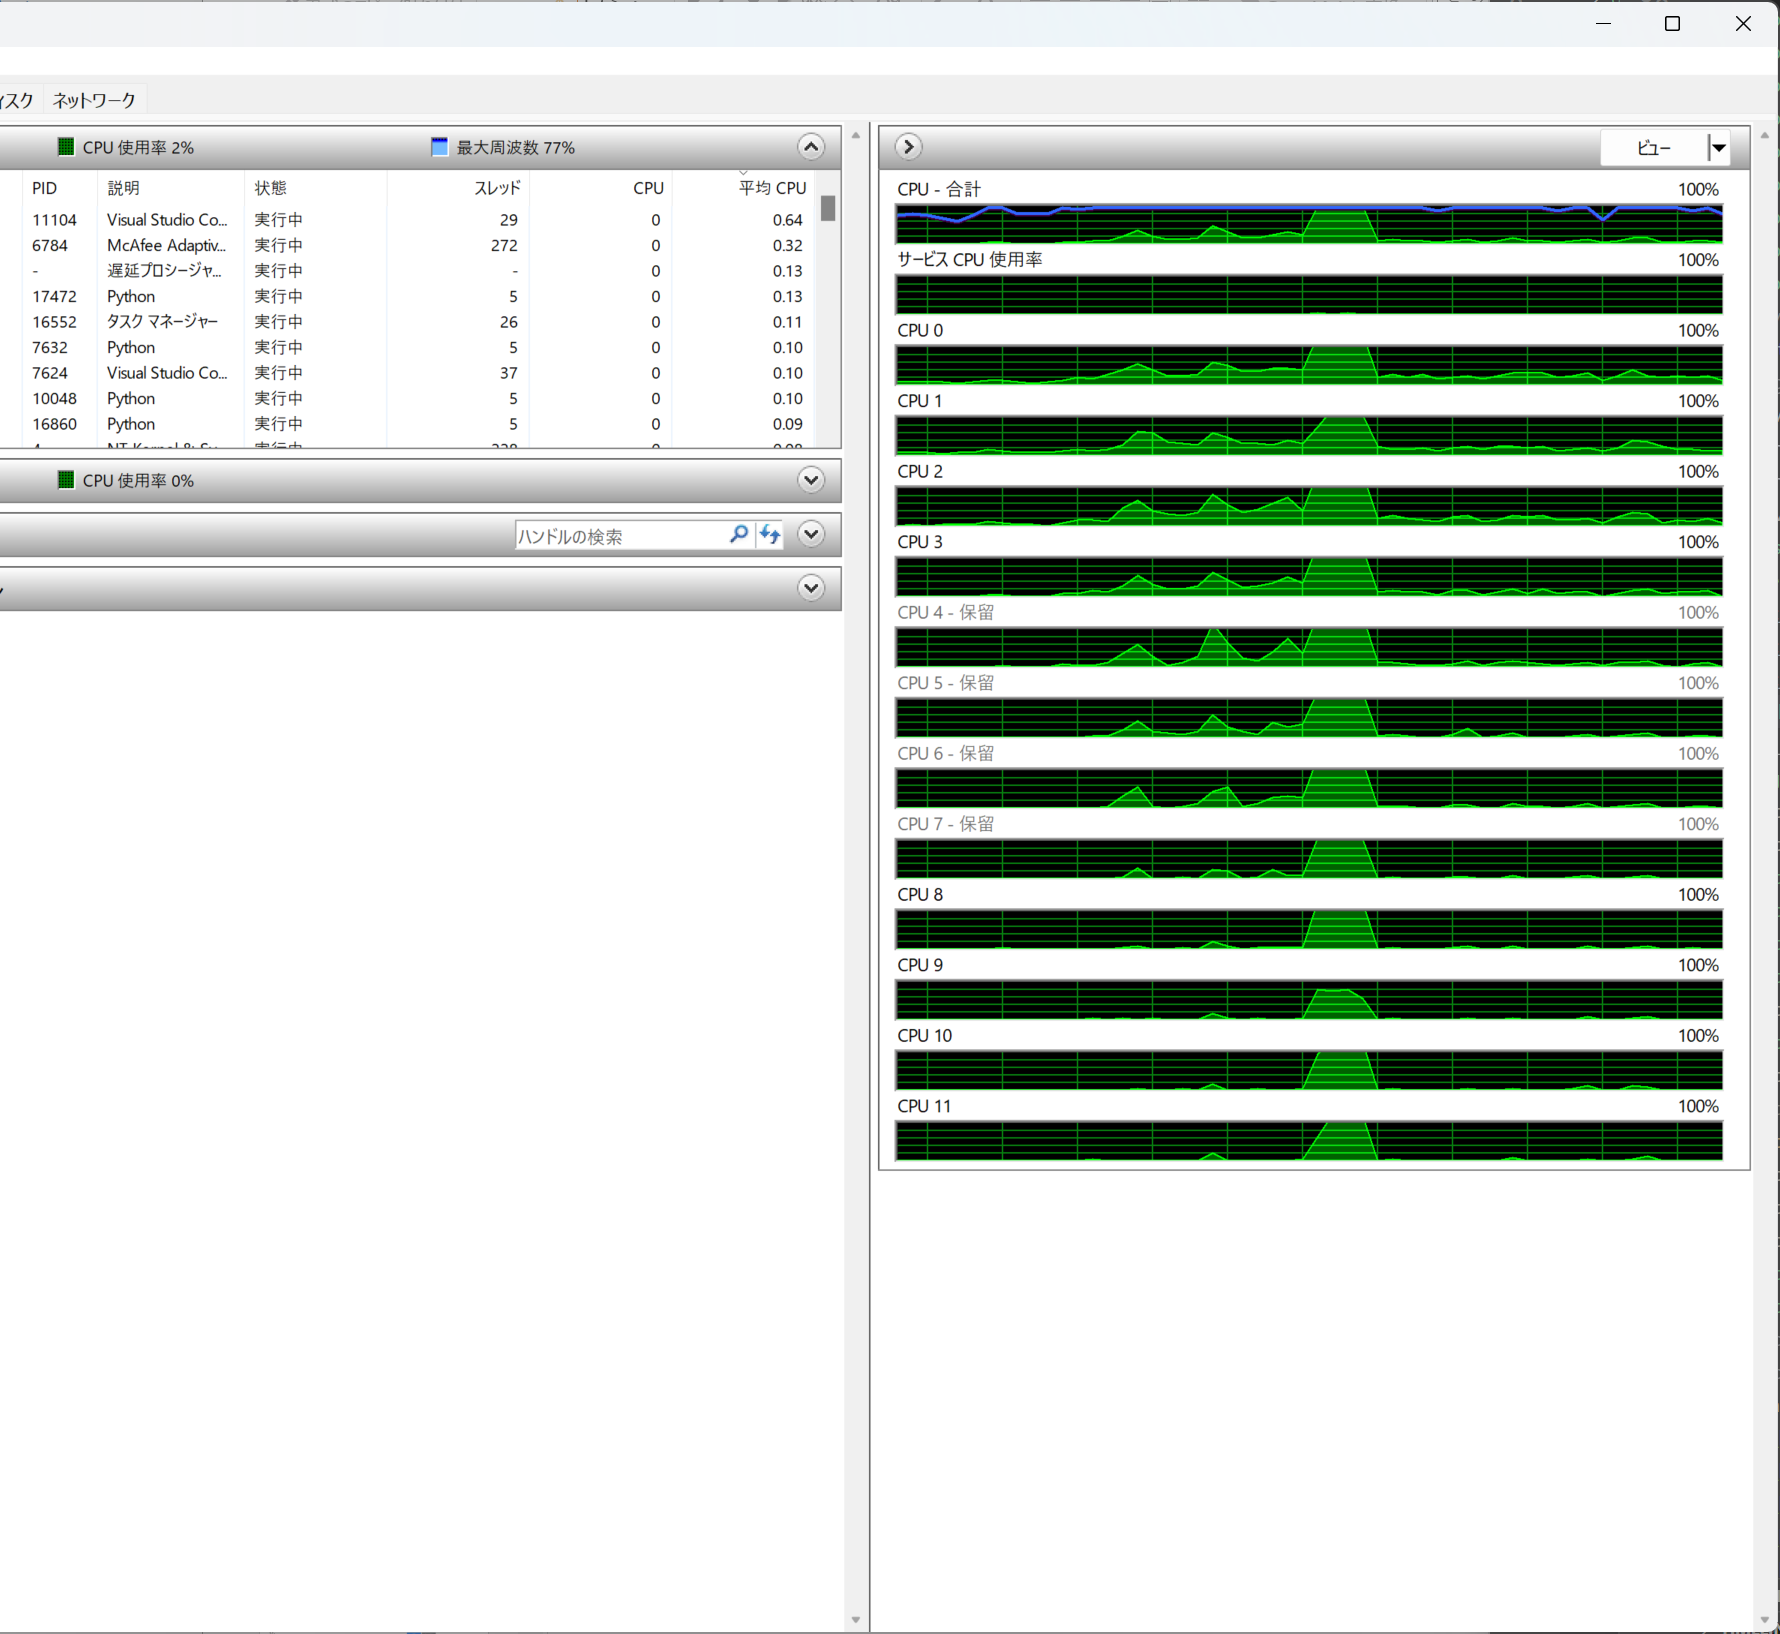
- CPU_COUNT = 6
TIMES = 25
N = 200
4.516061782836914
- CPU_COUNT = 7
TIMES = 24
N = 200
2.1445112228393555
- CPU_COUNT = 8
TIMES = 24
N = 200
2.207643508911133
- CPU_COUNT = 10
TIMES = 24
N = 200
2.3841946125030518
- CPU_COUNT = 12
TIMES = 24
N = 200
2.6013553142547607
- CPU_COUNT = 4
TIMES = 216
N = 200
46.22023248672485
- CPU_COUNT = 5
TIMES = 216
N = 200
33.92997908592224
- CPU_COUNT = 6
TIMES = 216
N = 200
29.20413327217102
- CPU_COUNT = 7
TIMES = 216
N = 200
- CPU_COUNT = 6
TIMES = 1000
N = 120
25.551272869110107
- CPU_COUNT = 6
TIMES = 500
N = 150
30.970653772354126

### プロセスのコアを増やす
- CPU_COUNT = 1
TIMES = 1
N = 450
14.117026805877686
- CPU_COUNT = 2
TIMES = 1
N = 450
8.790517568588257
- CPU_COUNT = 4
TIMES = 1
N = 450
7.048987627029419
- CPU_COUNT = 1
TIMES = 1
N = 500
18.069915771484375
- CPU_COUNT = 2
TIMES = 1
N = 500
11.19430923461914
- CPU_COUNT = 3
TIMES = 1
N = 500
9.89956259727478
- CPU_COUNT = 4
TIMES = 1
N = 500
8.694450855255127
- CPU_COUNT = 6
TIMES = 1
N = 500
9.29934024810791
- 早くなる

### プロセスに渡す引数をコアごとにひとまとまりで

In [3]:
from joblib import Parallel, delayed
import time
import numpy as np

CPU_COUNT = 6
TIMES = 500
N = 150

def wrap_calc(args):
    return calc(*args)

def calc(As, n):

    results = []
    for A in As:
        a = np.random.random((n, n))
        b = np.random.random((n, n))
        c = np.dot(a, b).reshape([n*n])

        g = [gauss(i, a=A, mu=n*n/2, sigma=n*n/8) for i in range(n*n)]
        # ガウシアンとのコンボリューション
        conv =  np.convolve(c, g, mode='same')
        # x軸の定義
        x =  np.array([i for i in range(n*n)])

        #4次関数でのフィッティング
        f1, f2, f3, f4, f5 = np.polyfit(x, conv, 4)
        results.append([f1, f2, f3, f4, f5])
    return results
    # fit = [func(i, f1, f2, f3, f4, f5) for i in x]

def gauss(x, a=1, mu=0, sigma=1):
    return a * np.exp(-(x - mu)**2 / (2*sigma**2))

As_list = np.array_split([i for i in range(TIMES)], CPU_COUNT)
job_args = [(As, N) for As in As_list]
start = time.time()

for result in Parallel(n_jobs=CPU_COUNT) ([delayed(wrap_calc) (args) for args in job_args]):
    pass
    # print(result)

print(time.time()-start)


30.994555711746216


- CPU_COUNT = 1
TIMES = 100
N = 120
57.02318453788757
- CPU_COUNT = 2
TIMES = 100
N = 120
16.495840549468994
- CPU_COUNT = 4
TIMES = 100
N = 120
5.342941045761108
- CPU_COUNT = 6
TIMES = 100
N = 120
3.455343246459961
- CPU_COUNT = 8
TIMES = 100
N = 120
1.8238143920898438
- CPU_COUNT = 10
TIMES = 100
N = 120
2.2694835662841797
- CPU_COUNT = 12
TIMES = 100
N = 120
2.543931245803833
- CPU_COUNT = 6
TIMES = 100
N = 150
7.218682289123535
- CPU_COUNT = 8
TIMES = 100
N = 150
2.704538345336914
- CPU_COUNT = 10
TIMES = 100
N = 150
2.960899591445923
- CPU_COUNT = 2
TIMES = 24
N = 200
17.42654275894165
- CPU_COUNT = 4
TIMES = 24
N = 200
5.8233983516693115
-CPU_COUNT = 4
TIMES = 25
N = 200
6.479995965957642
- CPU_COUNT = 5
TIMES = 24
N = 200
4.51461935043335
- CPU_COUNT = 6
TIMES = 24
N = 200
4.121129035949707
- CPU_COUNT = 6
TIMES = 25
N = 200
4.565927028656006
- CPU_COUNT = 8
TIMES = 24
N = 200
2.148132562637329
- CPU_COUNT = 10
TIMES = 24
N = 200
2.336297035217285
- CPU_COUNT = 12
TIMES = 24
N = 200
2.9048590660095215
- CPU_COUNT = 4
TIMES = 216
N = 200
46.031554222106934
- CPU_COUNT = 5
TIMES = 216
N = 200
34.17951488494873
- CPU_COUNT = 6
TIMES = 216
N = 200
29.025034427642822
- CPU_COUNT = 7
TIMES = 216
N = 200
10.274674892425537
- CPU_COUNT = 6
TIMES = 1000
N = 120
26.770368337631226
- CPU_COUNT = 6
TIMES = 500
N = 150
30.994555711746216


In [37]:
import re
result = {}
keywords = ['CPU_COUNT', 'TIMES', 'N']
def assort_result(data):
    lines = data.split('\n')
    buf = {}
    for line in lines:
        print(line)
        
        for key in keywords:
            if re.search(f'{key} ', line):
                searched = re.search('= ([.\d]*)', line)
                print(searched.group(1))
                buf[key] = searched.group(1)
                print(f'buf in loop = {buf}')
        matched = re.match('[\.\d]+', line)
        if matched is not None :
            print(f'buf = {buf}')
            result[matched.group(0)] = buf
            buf = {}
    print(result)
    result_keys = result.keys()
    print(result_keys)
    for key in result_keys:
        print(key, end=',')
        for keyword in keywords:
            print(result[key][keyword], end=',')
        print(end='\n')
        
        
data = '''- CPU_COUNT = 1
TIMES = 100
N = 120
56.57072305679321
- CPU_COUNT = 2
TIMES = 100
N = 120
16.48804497718811
- CPU_COUNT = 4
TIMES = 100
N = 120
5.196465015411377
- CPU_COUNT = 6
TIMES = 100
N = 120
3.4273998737335205
- CPU_COUNT = 8
TIMES = 100
N = 120
1.829620599746704
- CPU_COUNT = 10
TIMES = 100
N = 120
2.0630264282226562
- CPU_COUNT = 12
TIMES = 100
N = 120
2.358685255050659
- CPU_COUNT = 6
TIMES = 100
N = 150
7.114055156707764
- CPU_COUNT = 8
TIMES = 100
N = 150
2.6081085205078125
- CPU_COUNT = 2
TIMES = 24
N = 200
16.646991968154907
- CPU_COUNT = 4
TIMES = 24
N = 200
5.842790842056274
![image.png](attachment:image-2.png)
- CPU_COUNT = 4
TIMES = 25
N = 200
6.3791663646698
- CPU_COUNT = 5
TIMES = 24
N = 200
![image.png](attachment:image-3.png)
- CPU_COUNT = 6
TIMES = 24
N = 200
4.0602357387542725
![image.png](attachment:image.png)
- CPU_COUNT = 6
TIMES = 25
N = 200
4.516061782836914
- CPU_COUNT = 7
TIMES = 24
N = 200
2.1445112228393555
- CPU_COUNT = 8
TIMES = 24
N = 200
2.207643508911133
- CPU_COUNT = 10
TIMES = 24
N = 200
2.3841946125030518
- CPU_COUNT = 12
TIMES = 24
N = 200
2.6013553142547607'''
assort_result(data)

- CPU_COUNT = 1
1
buf in loop = {'CPU_COUNT': '1'}
TIMES = 100
100
buf in loop = {'CPU_COUNT': '1', 'TIMES': '100'}
N = 120
120
buf in loop = {'CPU_COUNT': '1', 'TIMES': '100', 'N': '120'}
56.57072305679321
buf = {'CPU_COUNT': '1', 'TIMES': '100', 'N': '120'}
- CPU_COUNT = 2
2
buf in loop = {'CPU_COUNT': '2'}
TIMES = 100
100
buf in loop = {'CPU_COUNT': '2', 'TIMES': '100'}
N = 120
120
buf in loop = {'CPU_COUNT': '2', 'TIMES': '100', 'N': '120'}
16.48804497718811
buf = {'CPU_COUNT': '2', 'TIMES': '100', 'N': '120'}
- CPU_COUNT = 4
4
buf in loop = {'CPU_COUNT': '4'}
TIMES = 100
100
buf in loop = {'CPU_COUNT': '4', 'TIMES': '100'}
N = 120
120
buf in loop = {'CPU_COUNT': '4', 'TIMES': '100', 'N': '120'}
5.196465015411377
buf = {'CPU_COUNT': '4', 'TIMES': '100', 'N': '120'}
- CPU_COUNT = 6
6
buf in loop = {'CPU_COUNT': '6'}
TIMES = 100
100
buf in loop = {'CPU_COUNT': '6', 'TIMES': '100'}
N = 120
120
buf in loop = {'CPU_COUNT': '6', 'TIMES': '100', 'N': '120'}
3.4273998737335205
buf = {'CPU_

In [30]:
import re
matched = re.match('[\d\.]+','23.5TIMES = 24')
print(matched)
print(matched.group(0))


<re.Match object; span=(0, 4), match='23.5'>
23.5
